# Análisis exploratorio de datos (EDA)

In [ ]:
import kagglehub
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import datetime as dt
from sklearn.decomposition import PCA

## 1. Carga y comprensión de los datos
- Dimensiones del dataset  
- Tipos de variables  
- Primeras visualizaciones (`head`, `info`, `describe`)

In [17]:
# ======================
# 0. Descarga y carga del dataset
# ======================
path = kagglehub.dataset_download("manishkc06/startup-success-prediction")
csv_path = os.path.join(path, "startup data.csv")
df = pd.read_csv(csv_path)

# ======================
# 1. Visualización inicial del dataset
# ======================
print("======================\nDimensiones del dataset:\n======================")
print(f"{df.shape}\n")

print("======================\nPrimeras cinco filas:\n======================")
print(df.head(), "\n")

print("======================\nResumen del dataset:\n======================")
print(df.info(), "\n")

print("======================\nEstadísticas descriptivas del dataset:\n======================")
print(df.describe(include='all'))

Dimensiones del dataset:
(923, 49)

Primeras cinco filas:
   Unnamed: 0 state_code   latitude   longitude zip_code       id  \
0        1005         CA  42.358880  -71.056820    92101   c:6669   
1         204         CA  37.238916 -121.973718    95032  c:16283   
2        1001         CA  32.901049 -117.192656    92121  c:65620   
3         738         CA  37.320309 -122.050040    95014  c:42668   
4        1002         CA  37.779281 -122.419236    94105  c:65806   

            city              Unnamed: 6               name  labels  ...  \
0      San Diego                     NaN        Bandsintown       1  ...   
1      Los Gatos                     NaN          TriCipher       1  ...   
2      San Diego      San Diego CA 92121              Plixi       1  ...   
3      Cupertino      Cupertino CA 95014  Solidcore Systems       1  ...   
4  San Francisco  San Francisco CA 94105     Inhale Digital       0  ...   

  object_id has_VC has_angel has_roundA  has_roundB  has_roundC  has_r

### Resumen del dataset: startup success prediction

Este conjunto de datos contiene información estructurada sobre 923 startups, con el objetivo de analizar sus características clave y predecir su probabilidad de éxito. La variable objetivo es `labels`, una variable binaria que toma el valor `1` si la startup ha tenido éxito y `0` en caso contrario.

Número de filas (startups): 923  
Número de columnas: 49

Tipos de variables:
- Variables categóricas: `state_code`, `state_code.1`, `zip_code`, `city`, `category_code`, `status`, `name`, `id`, `object_id`, `Unnamed: 6`
- Variables numéricas: `latitude`, `longitude`, `age_first_funding_year`, `age_last_funding_year`, `age_first_milestone_year`, `age_last_milestone_year`, `relationships`, `funding_rounds`, `funding_total_usd`, `milestones`, `avg_participants`
- Variables binarias: `has_VC`, `has_angel`, `has_roundA`, `has_roundB`, `has_roundC`, `has_roundD`, `is_CA`, `is_NY`, `is_MA`, `is_TX`, `is_otherstate`, `is_software`, `is_web`, `is_mobile`, `is_enterprise`, `is_advertising`, `is_gamesvideo`, `is_ecommerce`, `is_biotech`, `is_consulting`, `is_othercategory`, `is_top500`, `labels`

Variable objetivo:
- `labels`: Variable binaria de clasificación donde `1` indica que la startup ha tenido éxito y `0` que no lo ha tenido.

Variables candidatas para eliminar:
- `Unnamed: 0`: Índice artificial generado automáticamente al exportar el CSV.
- `Unnamed: 6`: Columna redundante con duplicación parcial de la ubicación (dirección).
- `state_code.1`: Duplicado de `state_code`, no aporta información adicional.
- `id`: Identificador único de la startup, irrelevante para el modelado.
- `object_id`: Identificador alternativo, redundante con `id`.

Variables relevantes (agrupadas por categoría):

Identificadores y localización:
- `id`, `object_id`: Identificadores únicos.
- `state_code`, `city`, `zip_code`, `latitude`, `longitude`
- `state_code.1`: Posible duplicado de `state_code`.

Temporalidad:
- `founded_at`, `closed_at`: Fechas de inicio y cierre.
- `first_funding_at`, `last_funding_at`: Fechas de primeras y últimas rondas.
- `age_first_funding_year`, `age_last_funding_year`, `age_first_milestone_year`, `age_last_milestone_year`: Diferencias temporales respecto al año de fundación.

Financiación e inversión:
- `funding_rounds`: Número total de rondas de inversión.
- `funding_total_usd`: Inversión total acumulada.
- `has_VC`, `has_angel`, `has_roundA`, `has_roundB`, `has_roundC`, `has_roundD`: Indicadores binarios de financiación por tipo y etapa.

Participación y relaciones:
- `avg_participants`: Media de participantes por ronda.
- `relationships`: Número de conexiones registradas.
- `milestones`: Número de hitos alcanzados.

Sector y categoría:
- `category_code`: Categoría principal.
- `is_software`, `is_web`, `is_mobile`, `is_enterprise`, `is_advertising`, `is_gamesvideo`, `is_ecommerce`, `is_biotech`, `is_consulting`, `is_othercategory`: Etiquetas binarias por sector.

Localización geográfica extendida:
- `is_CA`, `is_NY`, `is_MA`, `is_TX`, `is_otherstate`: Variables indicadoras del estado geográfico principal.

Métricas adicionales:
- `is_top500`: Si pertenece al ranking de las 500 principales.
- `status`: Estado actual de la startup (`acquired`, `closed`, etc.).

Observaciones iniciales:
- El dataset no contiene valores nulos significativos salvo en `closed_at`, `Unnamed: 6` y en las variables de hitos (`age_first_milestone_year`, `age_last_milestone_year`).
- La variable `labels` puede usarse directamente como variable objetivo para modelos de clasificación supervisada.
- Algunas variables redundantes o no informativas pueden ser eliminadas (`Unnamed: 0`, `Unnamed: 6`, `state_code.1`, `id`, `object_id`), ya que no aportan valor al análisis predictivo o son duplicadas.
- Será necesario realizar una exploración de correlación entre las variables financieras, geográficas y de hitos con respecto a `labels`.
- Las variables de fecha (`founded_at`, `closed_at`, `first_funding_at`, `last_funding_at`) están en formato de texto (`object`) y deben ser convertidas a formato `datetime` para permitir su análisis temporal y la generación de características derivadas.

## 2. Limpieza de datos

- Eliminación de columnas no informativas que no aportan valor al análisis
- Conversión de variables temporales a tipo datetime
- Detección y visualización de valores nulos para evaluar posibles imputaciones o descartes futuros
- Detección de valores atípicos en variables numéricas continuas mediante boxplots y la regla del IQR
- Verificación y recuperación de la variable `status` si no está presente en el DataFrame
- Identificación de variables categóricas de baja cardinalidad (≤ 10 categorías)



Resumen de valores nulos:
closed_at                   588
age_last_milestone_year     152
age_first_milestone_year    152
dtype: int64 



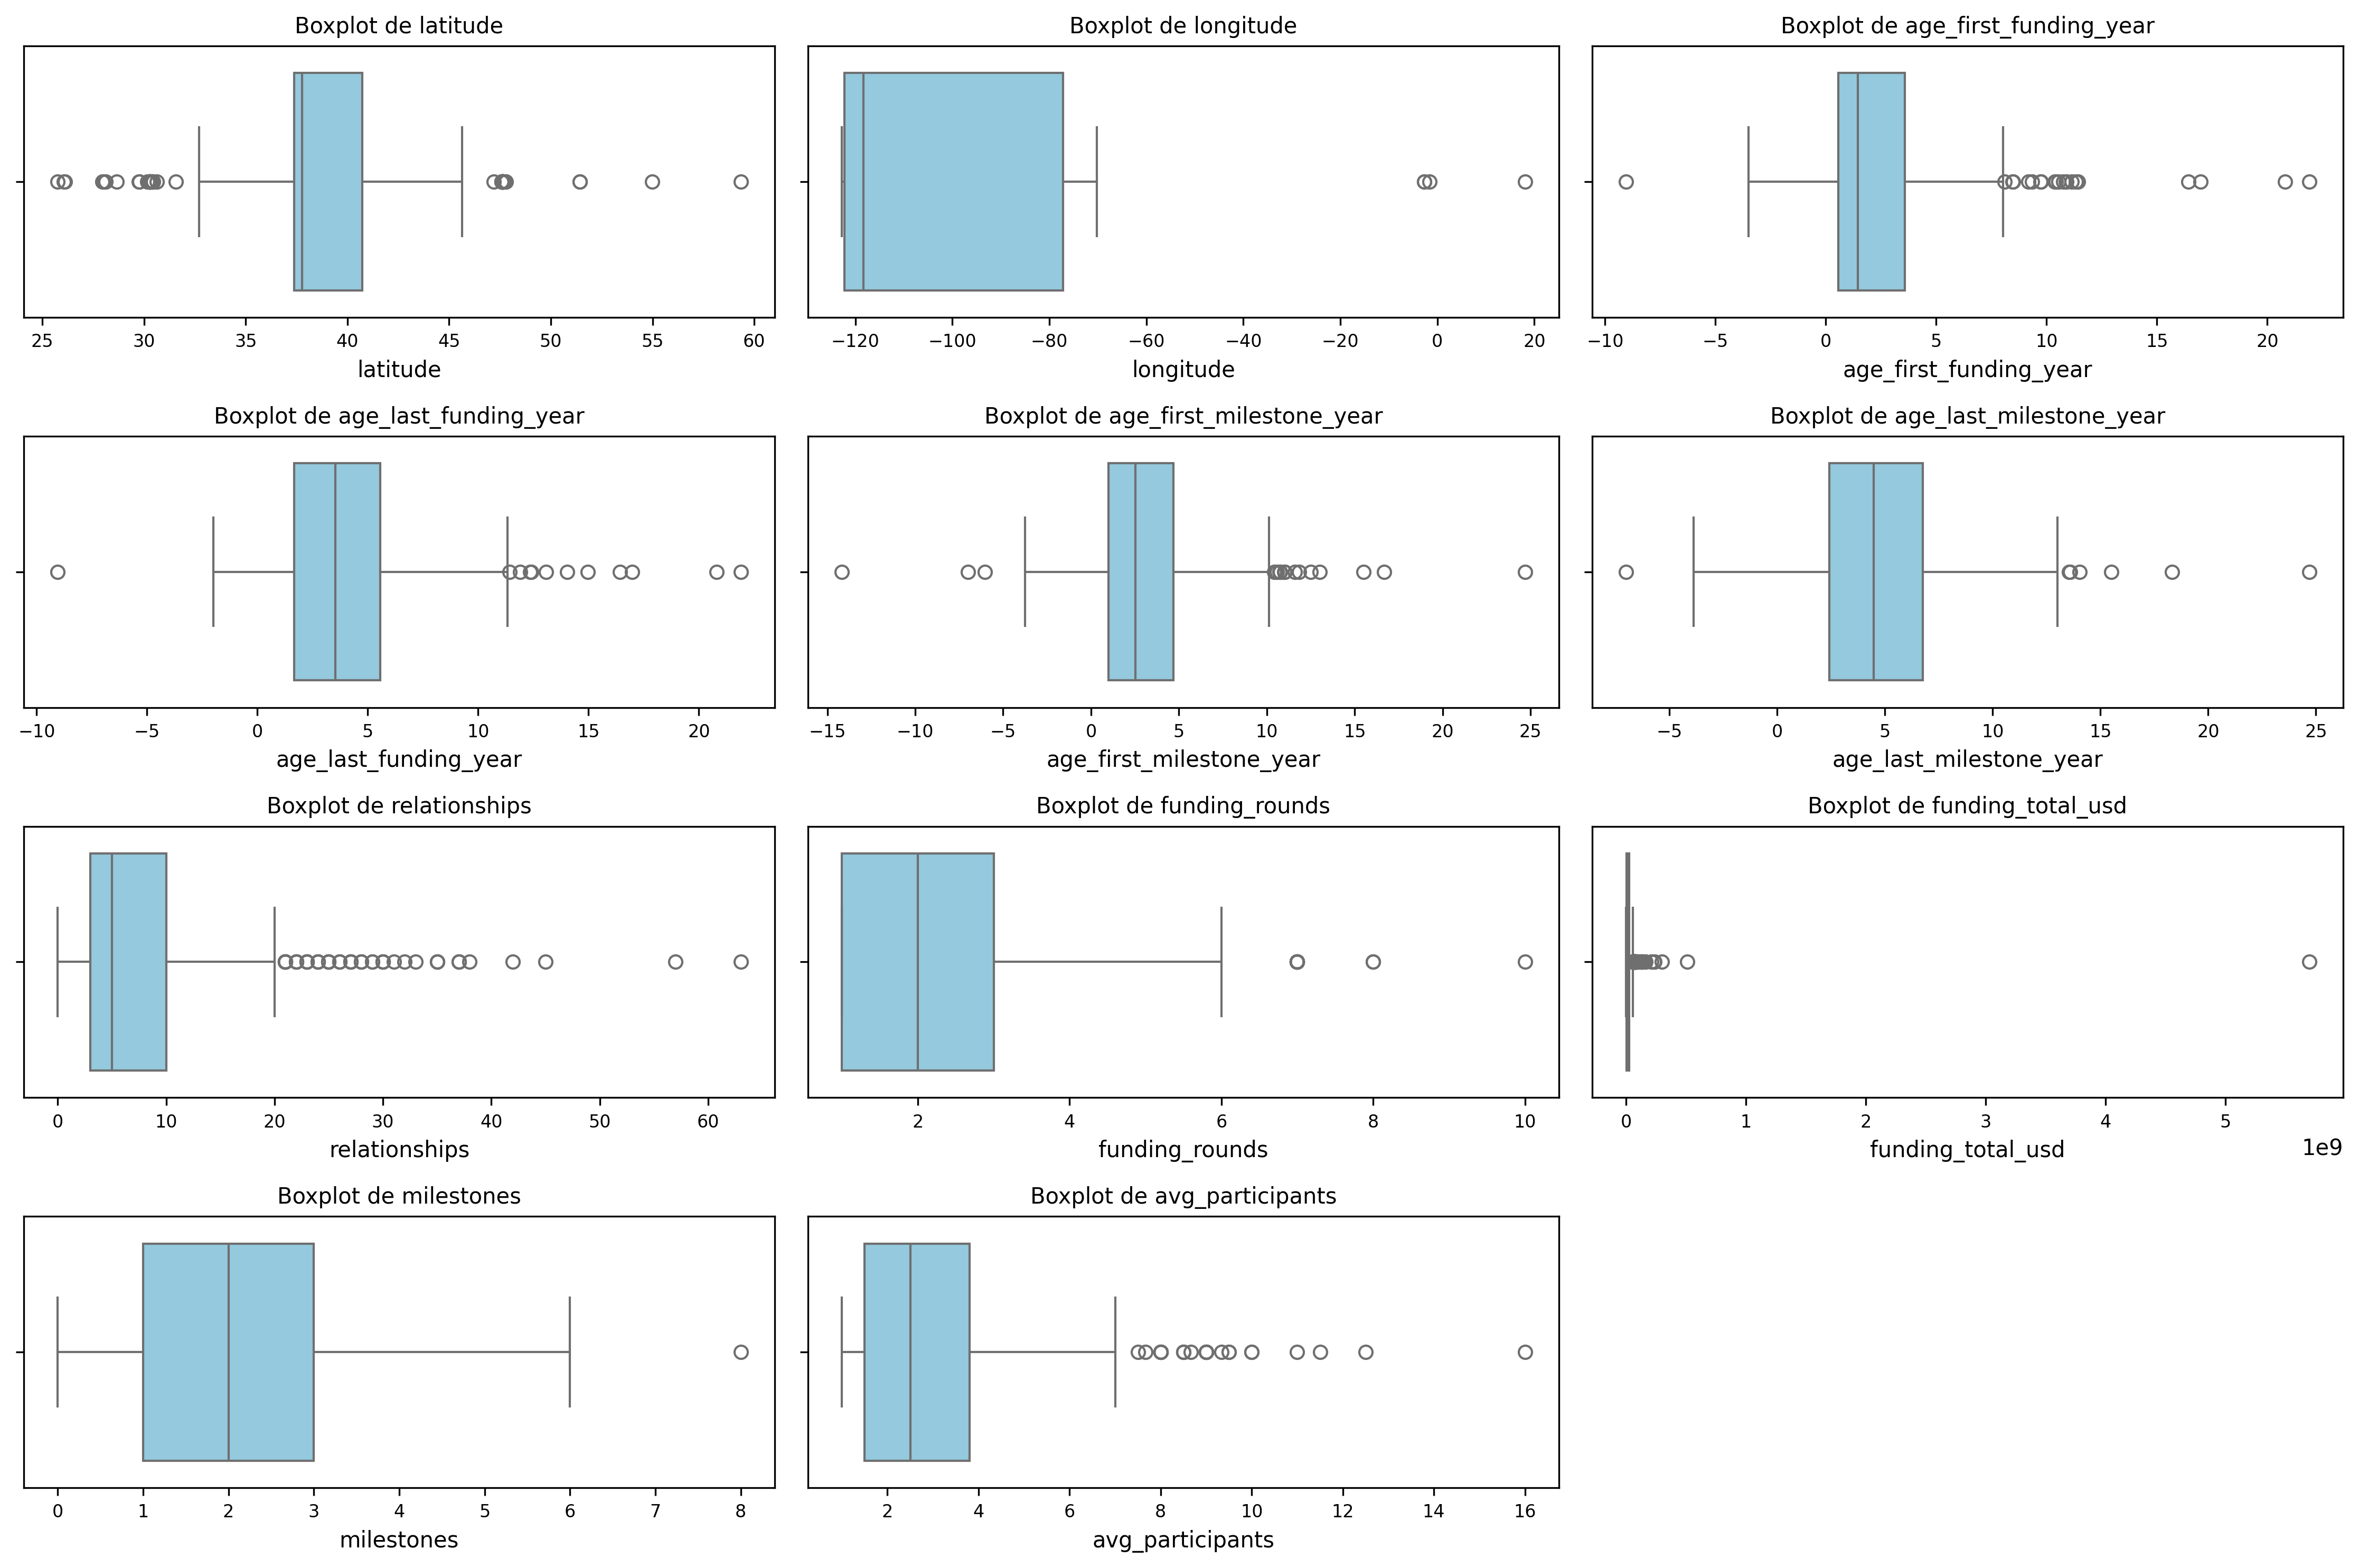


Conteo de outliers por IQR:
latitude: 78 posibles outliers.
longitude: 4 posibles outliers.
age_first_funding_year: 21 posibles outliers.
age_last_funding_year: 12 posibles outliers.
age_first_milestone_year: 17 posibles outliers.
age_last_milestone_year: 7 posibles outliers.
relationships: 60 posibles outliers.
funding_rounds: 16 posibles outliers.
funding_total_usd: 65 posibles outliers.
milestones: 1 posibles outliers.
avg_participants: 28 posibles outliers.

Resumen de variables categóricas:
state_code (35 únicos):
state_code
CA    488
NY    106
MA     83
WA     42
TX     42
Name: count, dtype: int64 

zip_code (382 únicos):
zip_code
94107    30
94105    23
95054    20
94103    19
94043    18
Name: count, dtype: int64 

city (221 únicos):
city
San Francisco    128
New York          91
Mountain View     47
Palo Alto         35
Austin            27
Name: count, dtype: int64 

category_code (35 únicos):
category_code
software       153
web            144
mobile          79
enterprise

In [18]:
# 2.1 eliminación de columnas no informativas
cols_to_drop = ['Unnamed: 0', 'Unnamed: 6', 'state_code.1', 'id', 'object_id', 'name']
df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)

# 2.2 conversión de fechas
for col in ['founded_at', 'closed_at', 'first_funding_at', 'last_funding_at']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# 2.3 detección de nulos
null_summary = df.isnull().sum().sort_values(ascending=False)
print("\n======================\nResumen de valores nulos:\n======================")
print(null_summary[null_summary > 0], "\n")

# 2.4 detección de outliers en continuas
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('labels')
binary_cols = [c for c in numeric_cols if df[c].nunique()==2]
cont_cols = [c for c in numeric_cols if c not in binary_cols]

n_cols, n_rows = 3, int(np.ceil(len(cont_cols)/3))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*2.5), dpi=300)
axes = axes.flatten()
for i,c in enumerate(cont_cols):
    sns.boxplot(x=df[c], ax=axes[i], color='skyblue')
    axes[i].set_title(f"Boxplot de {c}", fontsize=10)
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].set_ylabel("")
for j in range(i+1,len(axes)): fig.delaxes(axes[j])
fig.tight_layout()
plt.savefig("boxplots_continuas.png", bbox_inches='tight')
plt.show()

def marcar_outliers_iqr(s):
    q1,q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3-q1
    return (s < q1-1.5*iqr) | (s > q3+1.5*iqr)

print("\n======================\nConteo de outliers por IQR:\n======================")
for c in cont_cols:
    print(f"{c}: {marcar_outliers_iqr(df[c]).sum()} posibles outliers.")
print()

# 2.5 revisión de categóricas e inserción de status
if 'status' not in df.columns:
    raw = pd.read_csv(csv_path, usecols=['status'])
    df['status'] = raw['status']

# recálculo de categóricas
cat_cols = df.select_dtypes(include=['object']).columns
print("======================\nResumen de variables categóricas:\n======================")
for c in cat_cols:
    print(f"{c} ({df[c].nunique()} únicos):")
    print(df[c].value_counts().head(5), "\n")

# 2.6 identificación de baja cardinalidad
low_card = [c for c in cat_cols if df[c].nunique()<=10]
print("======================\nVariables de baja cardinalidad (≤ 10 categorías):\n======================")
print(low_card, "\n")

### Conclusión del análisis preliminar de limpieza de datos

- Se han detectado valores nulos relevantes en tres columnas:
  - `closed_at` presenta más del 60 % de valores ausentes, probablemente porque muchas startups aún están activas y no han cerrado.
  - `age_first_milestone_year` y `age_last_milestone_year` presentan aproximadamente un 16 % de valores nulos, lo cual puede indicar que algunas startups no han alcanzado hitos significativos (y no errores en la calidad del dato).

- El análisis de outliers mediante el método del rango intercuartílico (IQR) ha revelado la presencia de valores extremos en todas las variables numéricas continuas, especialmente:
  - `latitude` y `funding_total_usd`, que contienen una gran cantidad de valores extremos dispersos.
  - Variables como `relationships` y `avg_participants` también presentan asimetrías y posibles atípicos que podrían requerir un tratamiento específico si afectan negativamente a los modelos predictivos.

- En lo referente a las variables categóricas:
  - La variable `status` fue la única detectada con baja cardinalidad (2 categorías), por ello se propone su codificación posterior mediante one-hot encoding.
  - Variables como `state_code`, `city`, `zip_code` y `category_code` poseen alta cardinalidad y, por el momento, no se han transformado, dado que no es necesario en esta etapa exploratoria.


### 3. Ingeniería de características

- Derivar variables temporales (`lifetime_years`, `funding_delay_years`, `last_milestone_delay_years`, `post_funding_duration_years`) a partir de fechas clave, considerando una fecha de corte (`2025-01-01`) para startups activas.
- Eliminar observaciones con incoherencias cronológicas (valores negativos en variables derivadas).
- Agrupar sectores en categorías tecnológicas y no tecnológicas (`main_sector`), así como reducir la cardinalidad de ciudades mediante `city_grouped`.
- Escalar variables numéricas continuas (`funding_total_usd`, `relationships`, `avg_participants`) mediante normalización estándar (`StandardScaler`).
- Generar variables booleanas que indiquen presencia de hitos (`has_milestones`), disponibilidad de información temporal (`has_milestone_info`) y existencia de financiación avanzada (`has_late_funding`).
- Verificar el balance de clases de la variable objetivo (`labels`) como paso previo a técnicas de rebalanceo.

In [19]:
# ======================
# 3. Ingeniería de características
# ======================

# ======================
# 3.1 Creación de variables temporales derivadas
# ======================

print("======================\n3.1 Creación de variables temporales derivadas\n======================")

fecha_corte = pd.to_datetime("2025-01-01")

df['lifetime_years'] = ((df['closed_at'].fillna(fecha_corte) - df['founded_at']).dt.days / 365).round(2)
df['funding_delay_years'] = ((df['first_funding_at'] - df['founded_at']).dt.days / 365).round(2)
df['last_milestone_delay_years'] = ((df['last_funding_at'] - df['founded_at']).dt.days / 365).round(2)
df['post_funding_duration_years'] = ((df['closed_at'].fillna(fecha_corte) - df['last_funding_at']).dt.days / 365).round(2)

print(df[['lifetime_years', 'funding_delay_years', 'last_milestone_delay_years', 'post_funding_duration_years']].describe(), "\n")

# ======================
# 3.1.1 Eliminación de observaciones con inconsistencias temporales o valores negativos
# ======================

print("======================\nEliminación de inconsistencias temporales y edades negativas\n======================")

mask_incoherencia = (
    (df['lifetime_years'] < 0) |
    (df['funding_delay_years'] < 0) |
    (df['last_milestone_delay_years'] < 0) |
    (df['post_funding_duration_years'] < 0) |
    (df['age_first_funding_year'] < 0) |
    (df['age_last_funding_year'] < 0) |
    (df['age_first_milestone_year'] < 0) |
    (df['age_last_milestone_year'] < 0)
)

total_errores = mask_incoherencia.sum()
print(f"Observaciones eliminadas por inconsistencias temporales o edades negativas: {total_errores}\n")

df = df.loc[~mask_incoherencia].copy()

# ======================
# 3.2 Clasificación binaria del tipo de startup
# ======================

print("======================\n3.2 Clasificación de sector tecnológico\n======================")

sectores_tecnologicos = ['software', 'web', 'mobile', 'enterprise']
df.loc[:, 'main_sector'] = df['category_code'].apply(lambda x: 'tech' if x in sectores_tecnologicos else 'non_tech')

top_cities = df['city'].value_counts()
top_cities = top_cities[top_cities > 20].index
df.loc[:, 'city_grouped'] = df['city'].apply(lambda x: x if x in top_cities else 'other')

print("Distribución de tipo de startup (tech vs. non_tech):\n")
print(df['main_sector'].value_counts(), "\n")

print("Distribución de ciudades agrupadas:\n")
print(df['city_grouped'].value_counts(), "\n")

# ======================
# 3.3 Escalado de variables numéricas continuas
# ======================

print("======================\n3.3 Escalado de variables numéricas continuas\n======================")

vars_to_scale = ['funding_total_usd', 'relationships', 'avg_participants']
scaler = StandardScaler()

for var in vars_to_scale:
    df.loc[:, f'{var}_scaled'] = scaler.fit_transform(df[[var]])
    print(f"{var} → {var}_scaled")

print()

# ======================
# 3.4 Creación de variables booleanas adicionales
# ======================

print("======================\n3.4 Creación de variables booleanas adicionales\n======================")

df.loc[:, 'has_milestones'] = df['milestones'] > 0
df.loc[:, 'has_milestone_info'] = df['age_first_milestone_year'].notna()
df.loc[:, 'has_late_funding'] = (df['has_roundC'] == 1) | (df['has_roundD'] == 1)

print("Nuevas variables booleanas creadas:\n")
print(df[['has_milestones', 'has_milestone_info', 'has_late_funding']].sum(), "\n")

# ======================
# 3.5 Comprobación del balance de clases
# ======================

print("======================\n3.5 Comprobación del balance de clases\n======================")
print(df['labels'].value_counts(normalize=True).rename('proporción'), "\n")

# ======================
# 3.6 Eliminación de columnas redundantes tras ingeniería de características
# ======================

cols_to_remove_post_feature_eng = [
    'city',
    'category_code',
    'founded_at',
    'closed_at',
    'first_funding_at',
    'last_funding_at',
    'milestones',
    'has_roundC',
    'has_roundD',
    'funding_total_usd',
    'relationships',
    'avg_participants'
]

df.drop(columns=[c for c in cols_to_remove_post_feature_eng if c in df.columns], inplace=True)
print("Columnas redundantes eliminadas tras ingeniería de características.\n")

3.1 Creación de variables temporales derivadas
       lifetime_years  funding_delay_years  last_milestone_delay_years  \
count      923.000000           923.000000                  923.000000   
mean        14.518570             2.235677                    3.931398   
std          7.368597             2.510528                    2.967989   
min         -8.010000            -9.050000                   -9.050000   
25%          7.150000             0.575000                    1.670000   
50%         16.600000             1.450000                    3.530000   
75%         20.010000             3.575000                    5.560000   
max         28.410000            21.900000                   21.900000   

       post_funding_duration_years  
count                   923.000000  
mean                     10.586891  
std                       6.604788  
min                     -11.250000  
25%                       2.930000  
50%                      13.360000  
75%                      15

### Interpretación de resultados de la ingeniería de características

Variables temporales derivadas:
- `lifetime_years`: Años entre la fundación y el cierre (o fecha de corte), representa la duración total de actividad.
- `funding_delay_years`: Años transcurridos entre la fundación y la primera ronda de financiación.
- `last_milestone_delay_years`: Tiempo entre la fundación y la última ronda de financiación.
- `post_funding_duration_years`: Años desde la última financiación hasta el cierre (o fecha de corte).

Estas variables permiten capturar el ritmo de desarrollo y la longevidad de cada startup. Se detectaron valores negativos en algunas observaciones debido a inconsistencias cronológicas, que se corrigieron eliminando un pequeño subconjunto de registros afectados.

Clasificación binaria del sector:
- Se creó `main_sector` agrupando `category_code` en dos clases: `tech` si pertenece a los sectores software, web, mobile o enterprise, y `non_tech` en caso contrario.
- También se creó `city_grouped` para reducir la cardinalidad de `city`, agrupando como `other` aquellas ciudades con menos de 20 startups.

Transformaciones numéricas:
- Se estandarizaron las siguientes variables con `StandardScaler`:
  - `funding_total_usd_scaled`
  - `relationships_scaled`
  - `avg_participants_scaled`

Estas transformaciones normalizan la escala, facilitando su uso en modelos sensibles a las magnitudes.

Variables booleanas adicionales:
- `has_milestones`: Indica si la startup ha registrado al menos un hito (`milestones > 0`).
- `has_milestone_info`: Indica si existe información sobre el primer hito (`age_first_milestone_year` no nulo).
- `has_late_funding`: Indica si la startup ha recibido financiación avanzada (ronda C o D).

Estas variables sintetizan aspectos clave de actividad e inversión.

Balance de clases:
- `labels = 1`: 66 % (startups exitosas)
- `labels = 0`: 34 % (startups no exitosas)

Este desequilibrio motiva el análisis del uso de técnicas como SMOTE o ponderación de clases.

Eliminación de variables redundantes:
- Se eliminaron variables sustituidas por versiones más informativas:
  - `category_code` → `main_sector`
  - `city` → `city_grouped`
  - Fechas originales → variables derivadas temporales
  - `milestones`, `has_roundC`, `has_roundD` → booleanas correspondientes

Esta limpieza reduce la redundancia, mejora la interpretabilidad y evita colinealidad en el modelado.


## 4. Análisis univariado
- Distribución de variables numéricas  
- Distribución de variables categóricas  

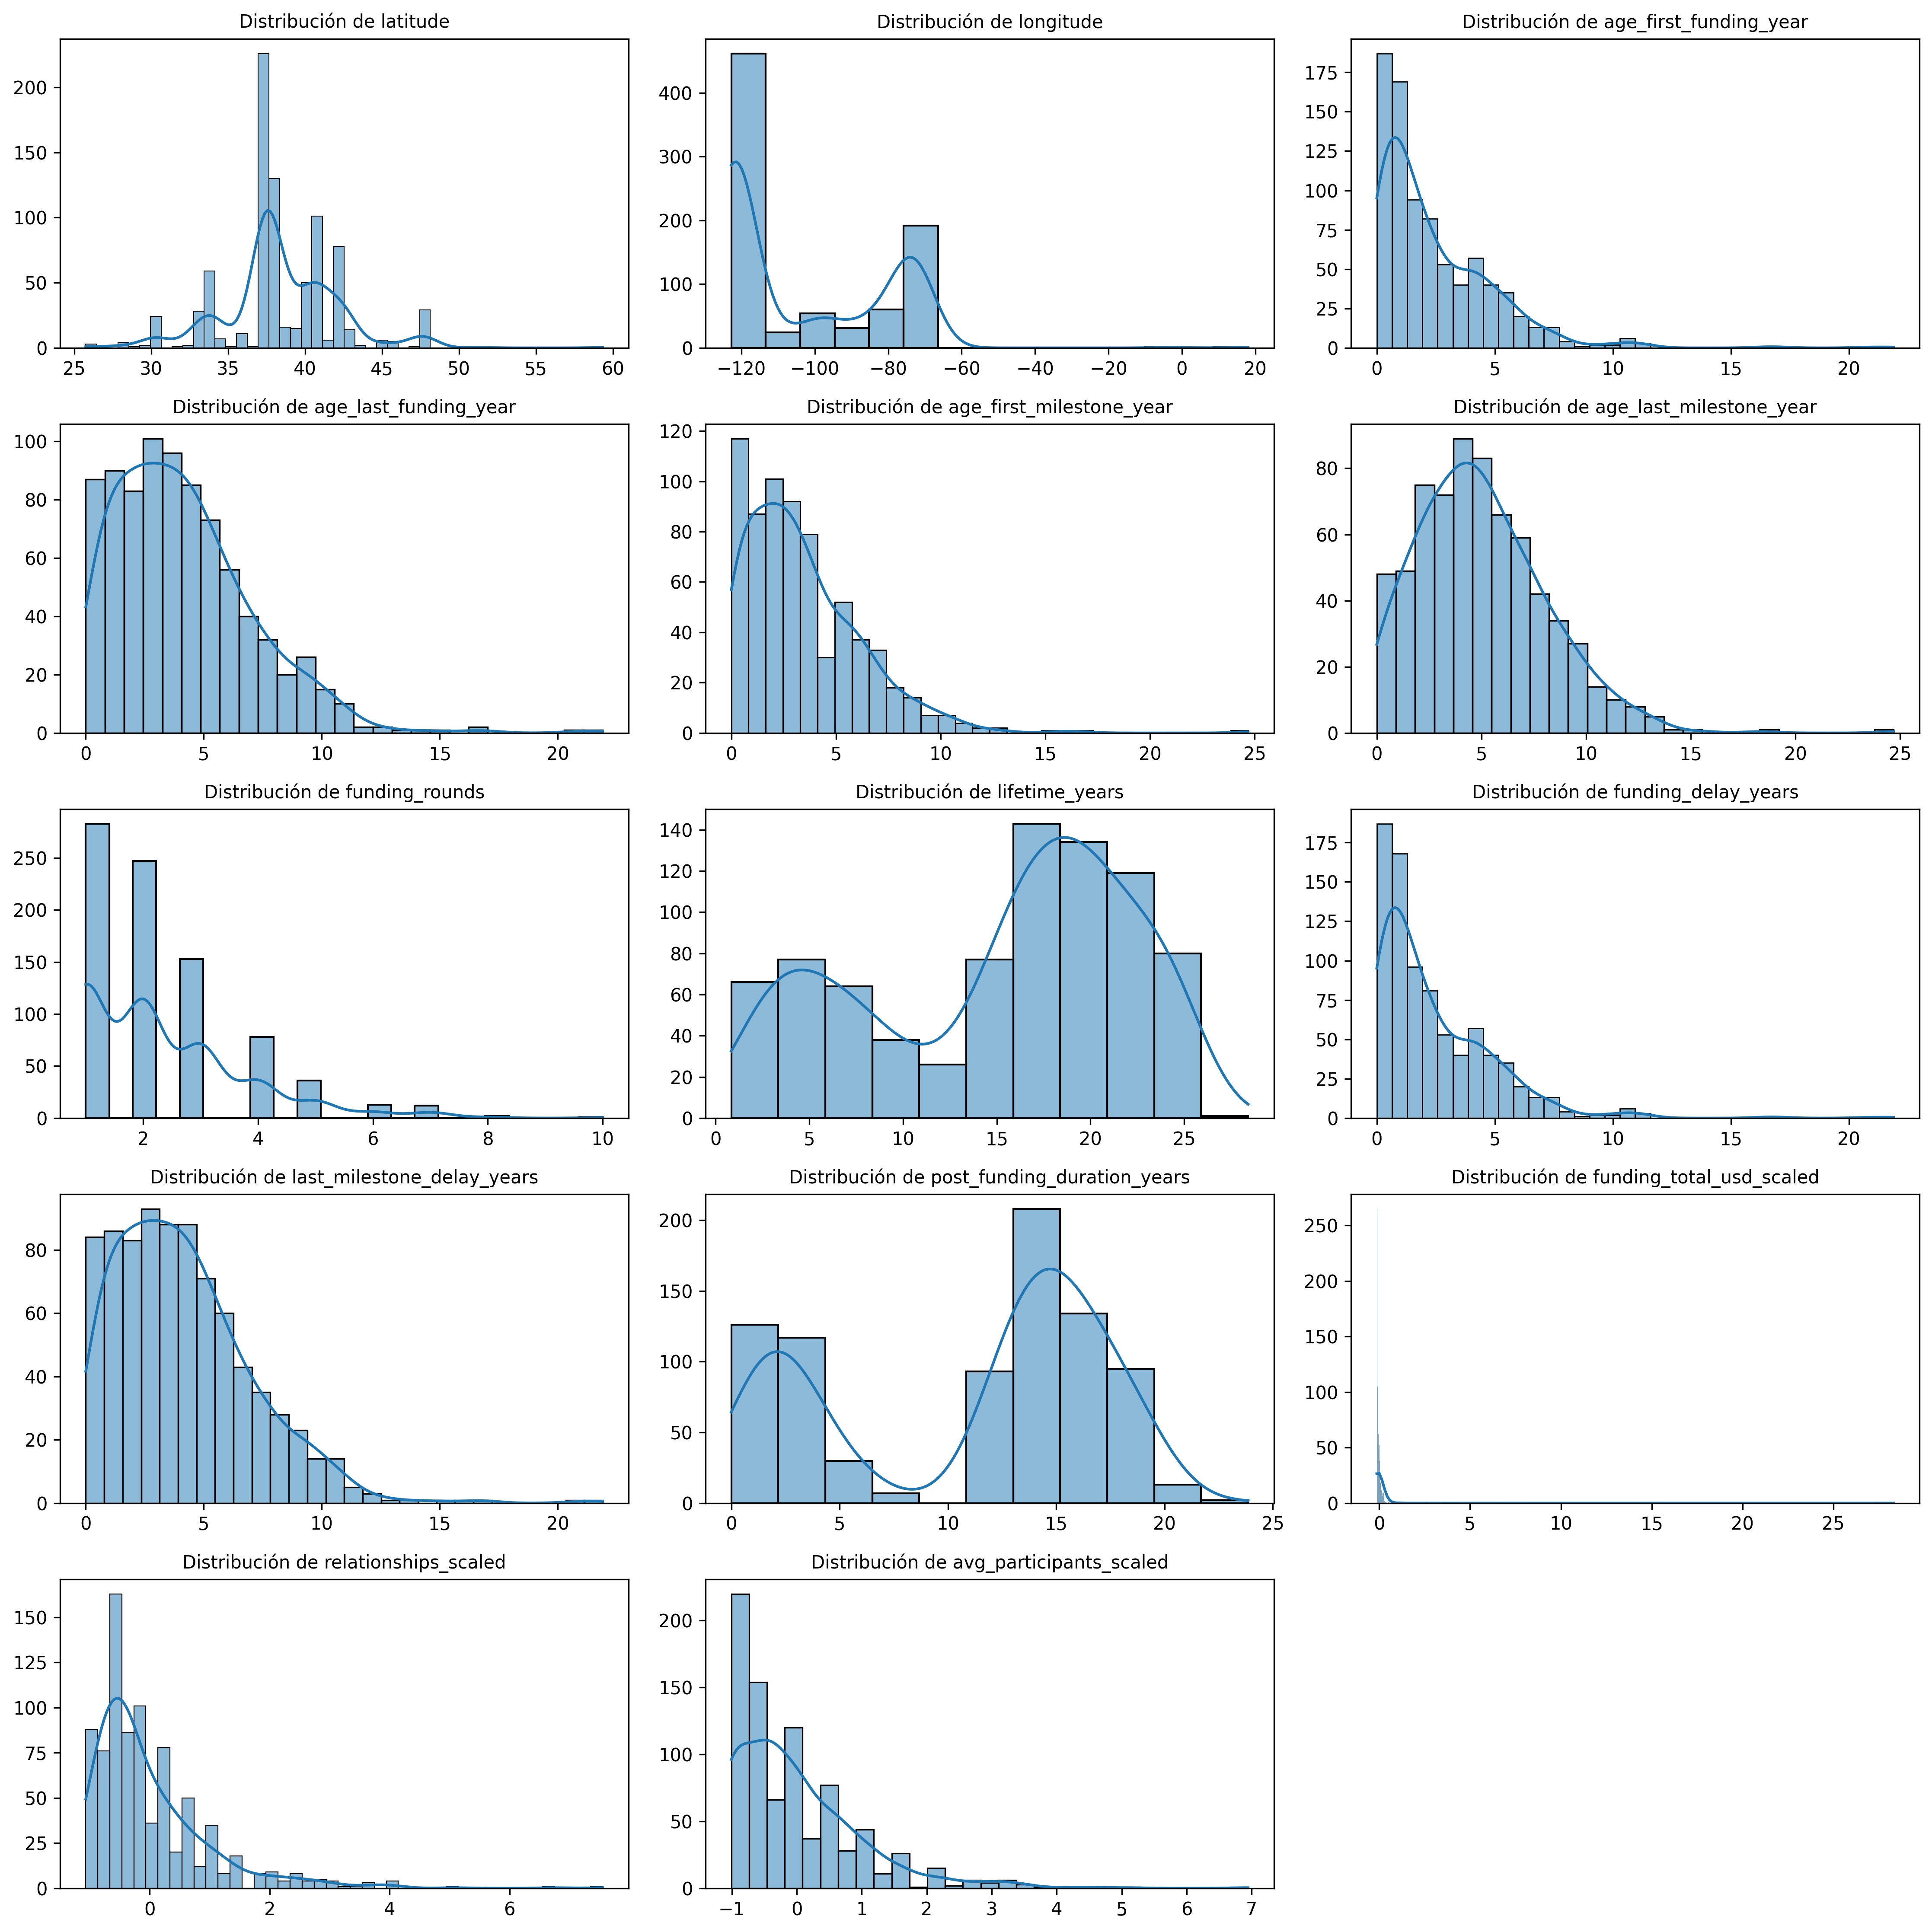

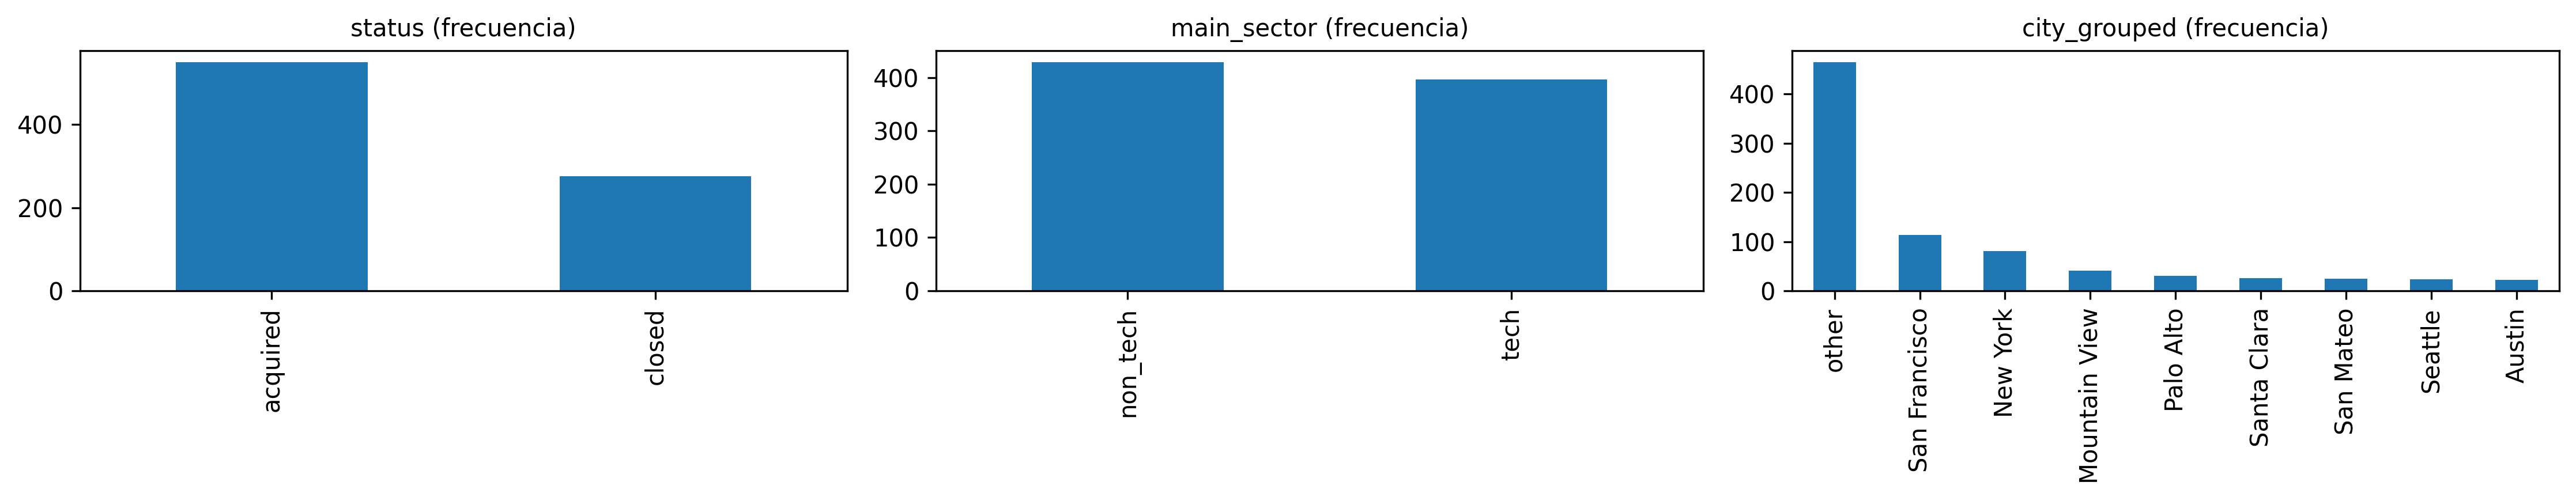

In [20]:
# ======================
# 4. Análisis univariado
# ======================

# ======================
# 4.1 Variables numéricas (excluyendo labels y binarias)
# ======================
num_all = df.select_dtypes(include='number').drop(columns=['labels'])
num_vars = [c for c in num_all.columns if df[c].nunique() > 2]

# ======================
# 4.2 Histograma en collage para variables numéricas continuas
# ======================
n_cols = 3
n_rows = int(np.ceil(len(num_vars) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3), dpi=300)
axes = axes.flatten()

for i, var in enumerate(num_vars):
    sns.histplot(df[var].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f"Distribución de {var}", fontsize=10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

# ======================
# 4.3 Variables categóricas (excluyendo binarias codificadas)
# ======================
cat_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()

# ======================
# 4.4 Gráficos de barras para categóricas con ≤ 20 categorías
# ======================
cat_vars_plot = [c for c in cat_vars if df[c].nunique() <= 20]

n_cols_cat = 3
n_rows_cat = int(np.ceil(len(cat_vars_plot) / n_cols_cat))
fig2, axes2 = plt.subplots(n_rows_cat, n_cols_cat, figsize=(n_cols_cat * 5, n_rows_cat * 3), dpi=300)
axes2 = axes2.flatten()

for i, var in enumerate(cat_vars_plot):
    df[var].value_counts().plot(kind='bar', ax=axes2[i])
    axes2[i].set_title(f"{var} (frecuencia)", fontsize=10)
    axes2[i].set_xlabel("")
    axes2[i].set_ylabel("")

for j in range(i + 1, len(axes2)):
    fig2.delaxes(axes2[j])

fig2.tight_layout()
plt.show()

### Interpretación del análisis univariado

#### Distribución de variables numéricas

El análisis de las distribuciones numéricas muestra que la mayoría de las variables presentan una fuerte asimetría positiva, lo cual indica la presencia de colas largas hacia la derecha y concentración de valores bajos:

- Variables como `funding_total_usd_scaled`, `funding_rounds`, `relationships_scaled`, `avg_participants_scaled`, `funding_delay_years`, `last_milestone_delay_years`, `age_last_funding_year` y `age_first_funding_year` exhiben distribuciones altamente sesgadas a la derecha, lo que sugiere que la mayoría de startups operan con pocos recursos o relaciones, pero existen algunas con valores extremadamente altos.
- Otras variables como `age_first_milestone_year` y `age_last_milestone_year` muestran distribuciones más simétricas o incluso bimodales, aunque también con cierta dispersión en sus valores.
- Las variables escaladas conservan la forma de la distribución original, pero centradas en media cero, lo que facilita su integración en modelos que requieren normalización, como regresión logística o redes neuronales.

Esta asimetría indica la posible necesidad de aplicar transformaciones logarítmicas o tratamiento de outliers durante la fase de preprocesamiento modelado.

#### Distribución de variables categóricas

- La variable `main_sector`, que clasifica a las startups como tecnológicas (`tech`) o no tecnológicas (`non_tech`), presenta una distribución equilibrada que permitirá su uso como predictor binario sin sesgos de clase.
- La variable `city_grouped` evidencia una fuerte concentración en la categoría `other`, lo que refleja que la mayoría de startups se distribuyen entre muchas ciudades con baja frecuencia individual. No obstante, destacan hubs como San Francisco, New York y Mountain View, confirmando la centralización geográfica en ecosistemas tecnológicos concretos.

Estas representaciones categóricas agregadas permiten mantener la interpretabilidad y reducen la complejidad del modelo al evitar una alta cardinalidad.


### 5. Análisis bivariado y multivariado
- Correlación entre variables numéricas (heatmap)  
- Análisis de dependencia entre variables categóricas y la variable objetivo  
- Análisis de varianza o pruebas estadísticas (si aplica)

5.1 Mapa de calor de correlación entre variables numéricas


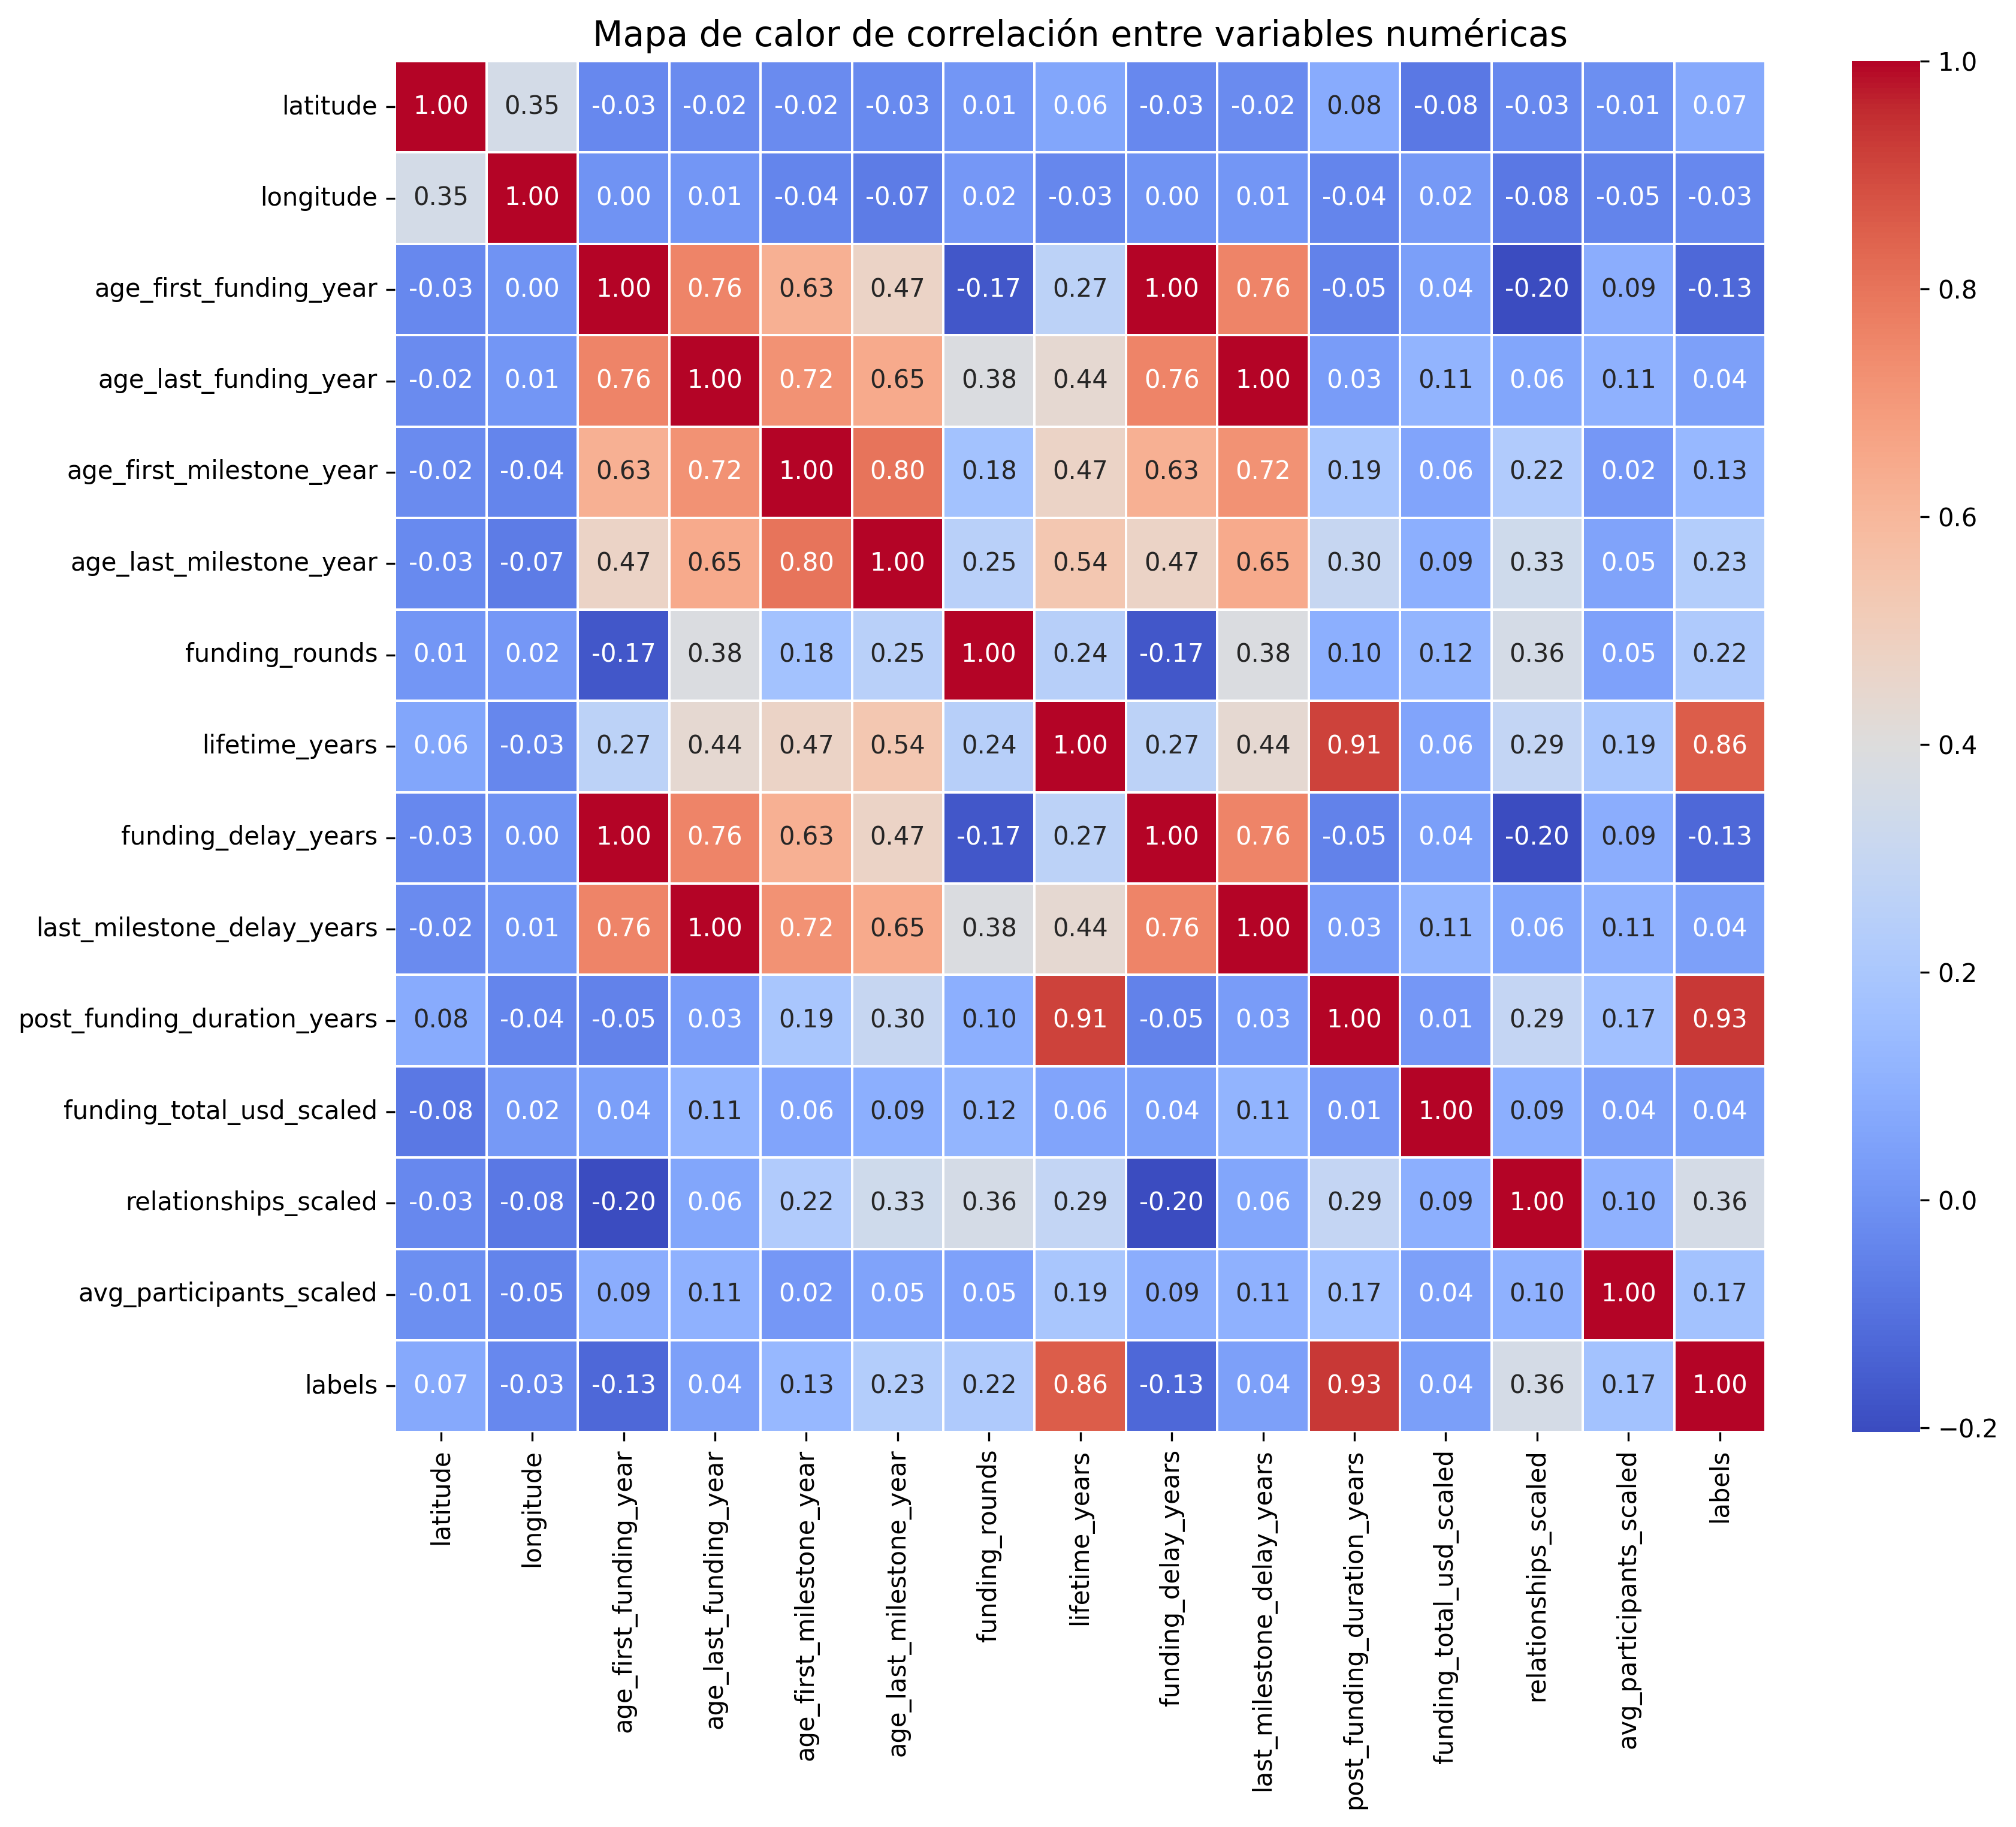


Variables con alta correlación con la variable objetivo (|r| ≥ 0.3):

post_funding_duration_years    0.934072
lifetime_years                 0.857518
relationships_scaled           0.358599
Name: labels, dtype: float64


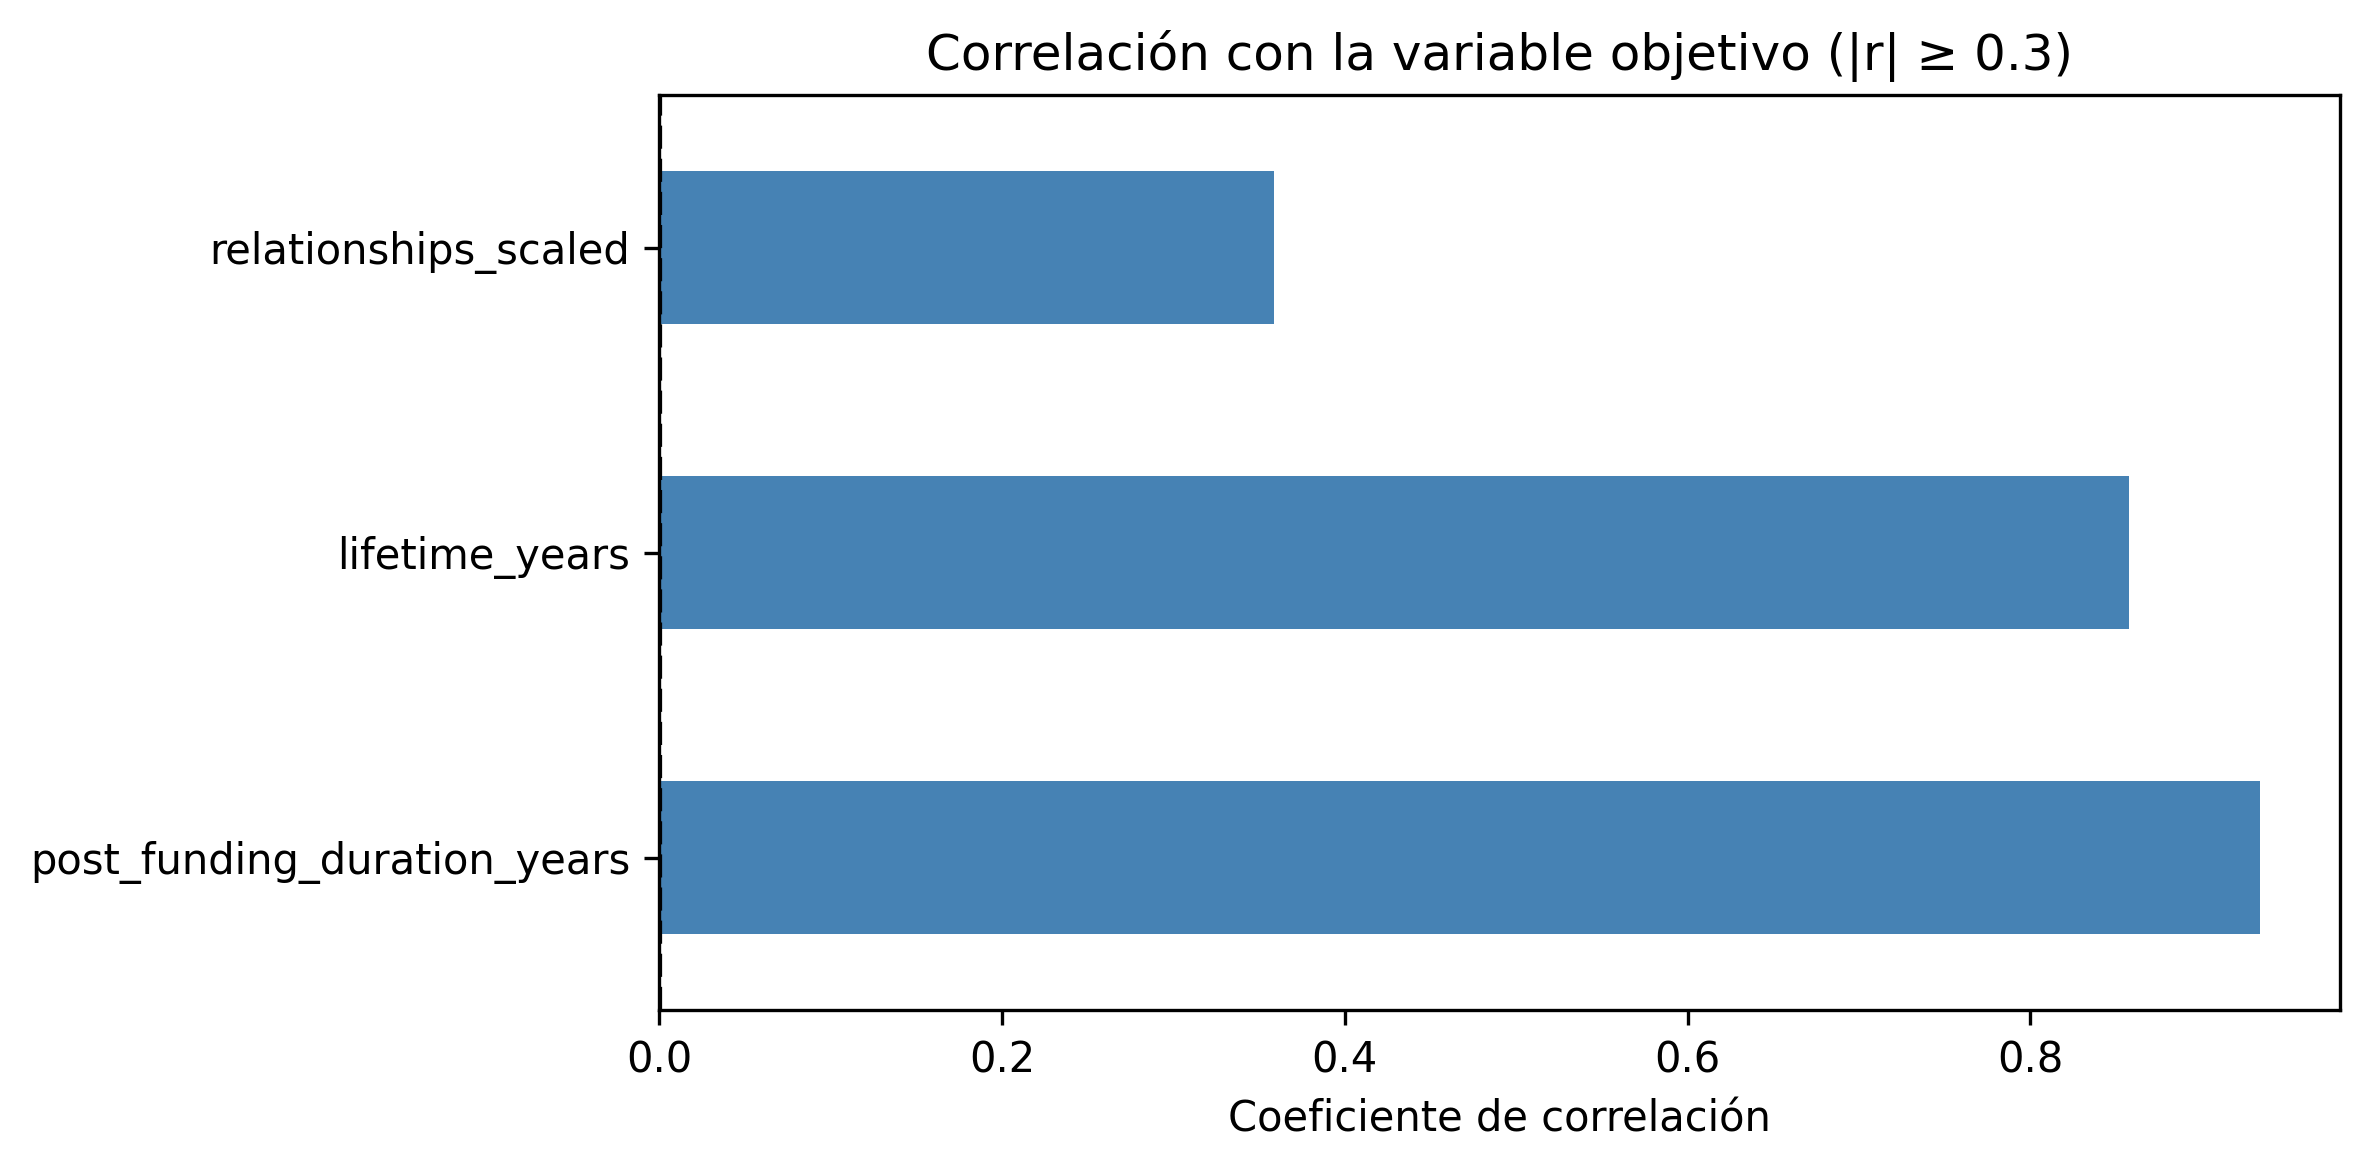

5.2 Asociación entre variables categóricas y la variable objetivo

Distribución de etiquetas según main_sector:

labels              0         1
main_sector                    
non_tech     0.363636  0.636364
tech         0.300505  0.699495

Distribución de etiquetas según city_grouped:

labels                0         1
city_grouped                     
Austin         0.318182  0.681818
Mountain View  0.243902  0.756098
New York       0.234568  0.765432
Palo Alto      0.266667  0.733333
San Francisco  0.230088  0.769912
San Mateo      0.291667  0.708333
Santa Clara    0.384615  0.615385
Seattle        0.347826  0.652174
other          0.387097  0.612903

Distribución de etiquetas según has_milestones:

labels                 0         1
has_milestones                    
False           0.671429  0.328571
True            0.264234  0.735766

Distribución de etiquetas según has_milestone_info:

labels                     0         1
has_milestone_info                    
False          

In [21]:
# ======================
# 5. Análisis bivariado y multivariado
# ======================

# ======================
# 5.1 Mapa de calor de correlación entre variables numéricas
# ======================

print("======================\n5.1 Mapa de calor de correlación entre variables numéricas\n======================")

# Seleccionamos variables numéricas excluyendo binarias
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols = [col for col in num_cols if df[col].nunique() > 2 and col != 'labels']

# Matriz de correlación de Pearson
corr_matrix = df[num_cols + ['labels']].corr()

# Visualización del heatmap
plt.figure(figsize=(12, 10), dpi=300)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Mapa de calor de correlación entre variables numéricas", fontsize=14)
plt.tight_layout()
plt.show()

# Filtrado de correlaciones con la variable objetivo
umbral = 0.3
corr_with_target = corr_matrix['labels'].drop('labels')
corr_altas = corr_with_target[abs(corr_with_target) >= umbral].sort_values(ascending=False)

print("\n======================")
print("Variables con alta correlación con la variable objetivo (|r| ≥ 0.3):")
print("======================\n")
print(corr_altas)

# Gráfico de barras de correlaciones altas
plt.figure(figsize=(8, 4), dpi=300)
corr_altas.plot(kind='barh', color='steelblue')
plt.axvline(x=0, color='black', linestyle='--')
plt.title("Correlación con la variable objetivo (|r| ≥ 0.3)")
plt.xlabel("Coeficiente de correlación")
plt.tight_layout()
plt.show()

# ======================
# 5.2 Asociación entre variables categóricas y la variable objetivo
# ======================

print("======================\n5.2 Asociación entre variables categóricas y la variable objetivo\n======================")

cat_vars = ['main_sector', 'city_grouped', 'has_milestones', 'has_milestone_info', 'has_late_funding']
for var in cat_vars:
    crosstab = pd.crosstab(df[var], df['labels'], normalize='index')
    print(f"\nDistribución de etiquetas según {var}:\n")
    print(crosstab)

# ======================
# 5.3 Pruebas estadísticas de significancia
# ======================

print("\n======================\n5.3 Pruebas estadísticas\n======================")

# Prueba t de Student entre clases de la variable objetivo
for var in num_cols:
    grupo0 = df[df['labels'] == 0][var]
    grupo1 = df[df['labels'] == 1][var]
    t_stat, p_val = stats.ttest_ind(grupo0, grupo1, nan_policy='omit', equal_var=False)
    print(f"{var}: t = {t_stat:.2f}, p = {p_val:.4f}")

### 6. Visualización de datos
- Histogramas, boxplots, violin plots  
- Diagramas de dispersión y pairplots  
- Diagramas de barras y pastel para categóricas

### Interpretación del análisis bivariado y multivariado

#### Correlación entre variables numéricas y la variable objetivo

El análisis de la matriz de correlación con respecto a la variable objetivo `labels` revela relaciones notables que deben considerarse en la fase de modelado:

- `post_funding_duration_years` presenta una correlación extremadamente alta (r ≈ 0.94), lo que indica que el tiempo transcurrido desde la última financiación hasta el cierre (o la fecha de corte) está fuertemente asociado con startups exitosas.
- `lifetime_years` también mantiene una correlación fuerte (r ≈ 0.86), lo que sugiere que la longevidad empresarial se relaciona directamente con el éxito.
- `relationships_scaled` muestra una correlación moderada (r ≈ 0.35), implicando que una red empresarial más amplia puede contribuir a un mayor rendimiento de la startup.

Estas correlaciones indican que estas variables tienen un potencial predictivo elevado y deben priorizarse en la selección de características para los modelos.

#### Asociación entre variables categóricas y la variable objetivo

El análisis de proporciones entre categorías y la variable `labels` muestra patrones consistentes:

- Las startups tecnológicas (`tech`) presentan una mayor tasa de éxito (69 %) frente a las no tecnológicas (`non_tech`, 64 %), lo que justifica su uso como variable categórica relevante.
- La variable `city_grouped` muestra cómo ciertos hubs geográficos (San Francisco, New York, Mountain View) están fuertemente asociados con startups exitosas, todas con tasas de éxito superiores al 75 %, en contraste con el grupo `other` (61 %).
- Las startups con hitos (`has_milestones = True`) o con información de hitos (`has_milestone_info = True`) presentan tasas de éxito significativamente superiores (73 %) en comparación con aquellas que carecen de esta información (33 %).
- La financiación en etapas avanzadas (`has_late_funding = True`) se asocia con una tasa de éxito del 80 %, lo que refuerza su valor como indicador binario.

Estas asociaciones refuerzan la utilidad de estas variables categóricas para segmentar eficazmente el comportamiento de éxito y deben integrarse como predictores discretos.

#### Pruebas estadísticas de significancia

Las pruebas t de Student aplicadas a las variables numéricas permiten detectar diferencias significativas entre startups exitosas y no exitosas:

- Las variables más discriminativas incluyen `post_funding_duration_years`, `lifetime_years`, `funding_rounds`, `relationships_scaled` y `avg_participants_scaled`, todas con p-valores inferiores a 0.001, lo que indica diferencias estadísticamente significativas entre grupos.
- También se detectan diferencias en variables temporales como `funding_delay_years`, `age_first_milestone_year` y `age_last_milestone_year`, confirmando que los patrones temporales de financiación e hitos son factores explicativos clave.
- En cambio, variables como `longitude`, `latitude` o `funding_total_usd_scaled` no presentan diferencias significativas, por lo que podrían tener un papel secundario o incluso ser descartadas en algunas configuraciones de modelado.

Este análisis combinado valida tanto la relevancia estadística como el valor predictivo de múltiples variables, sirviendo de base para una futura selección de características más sólida y justificada.

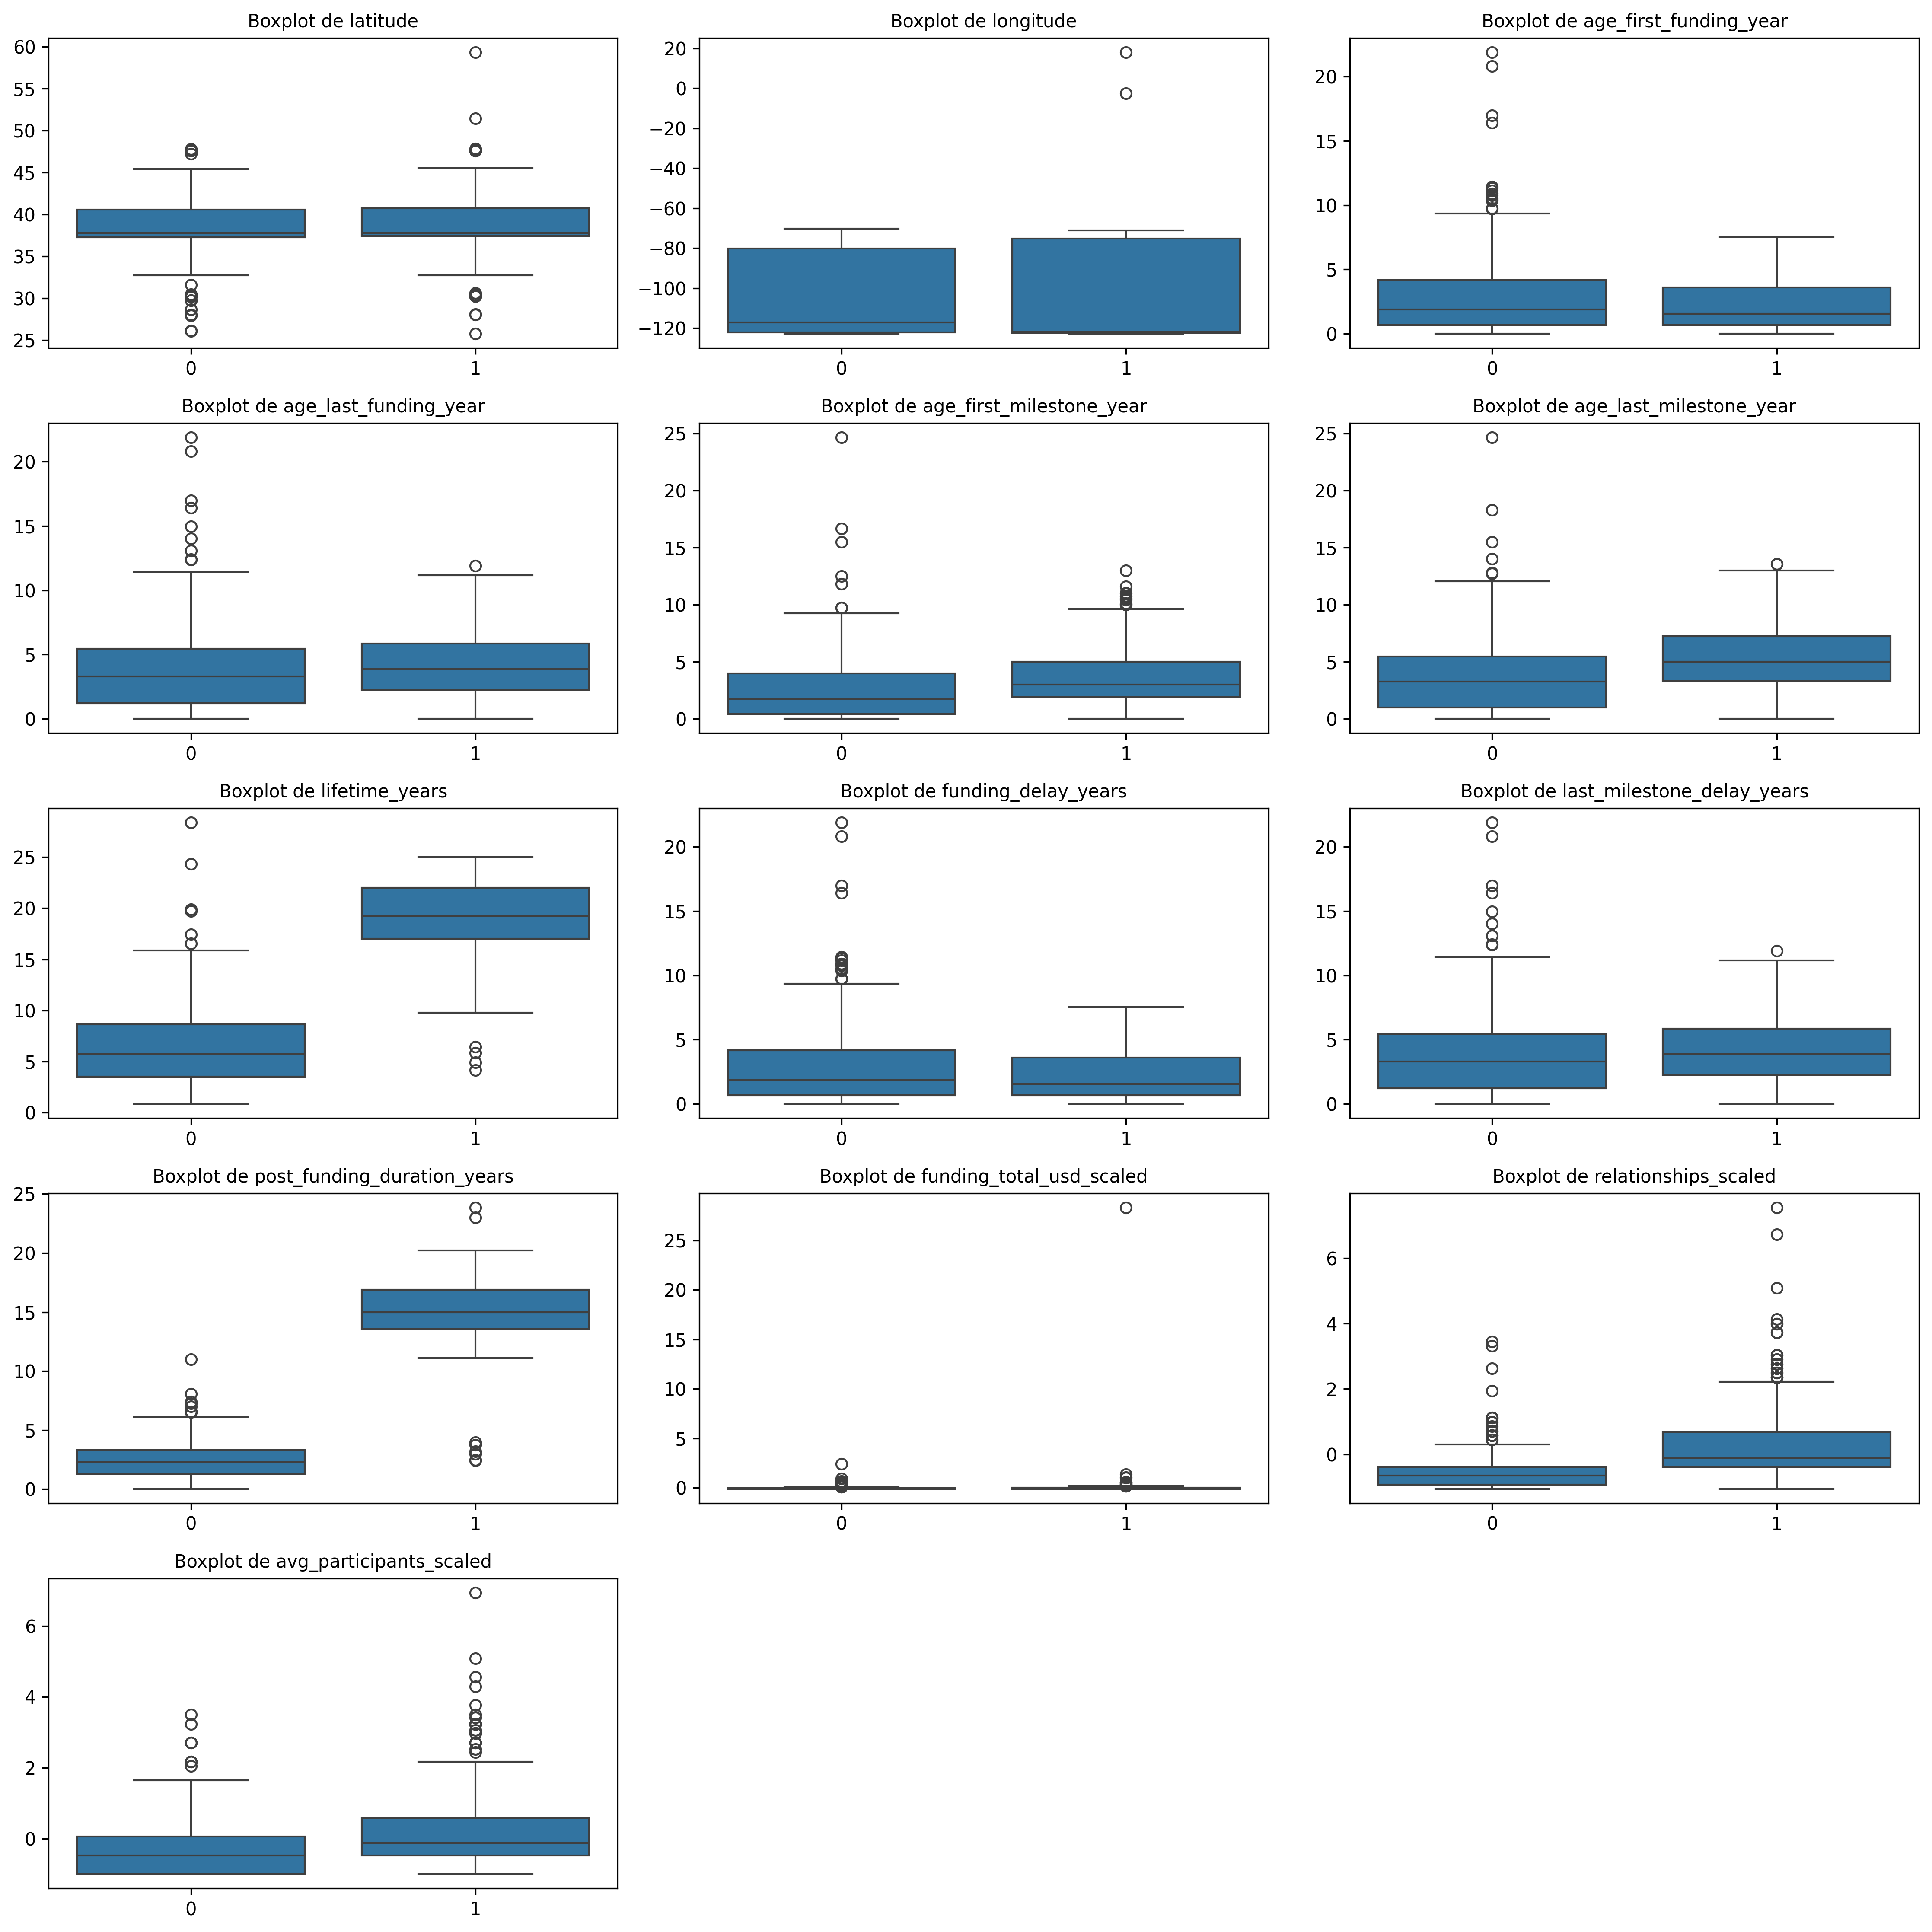

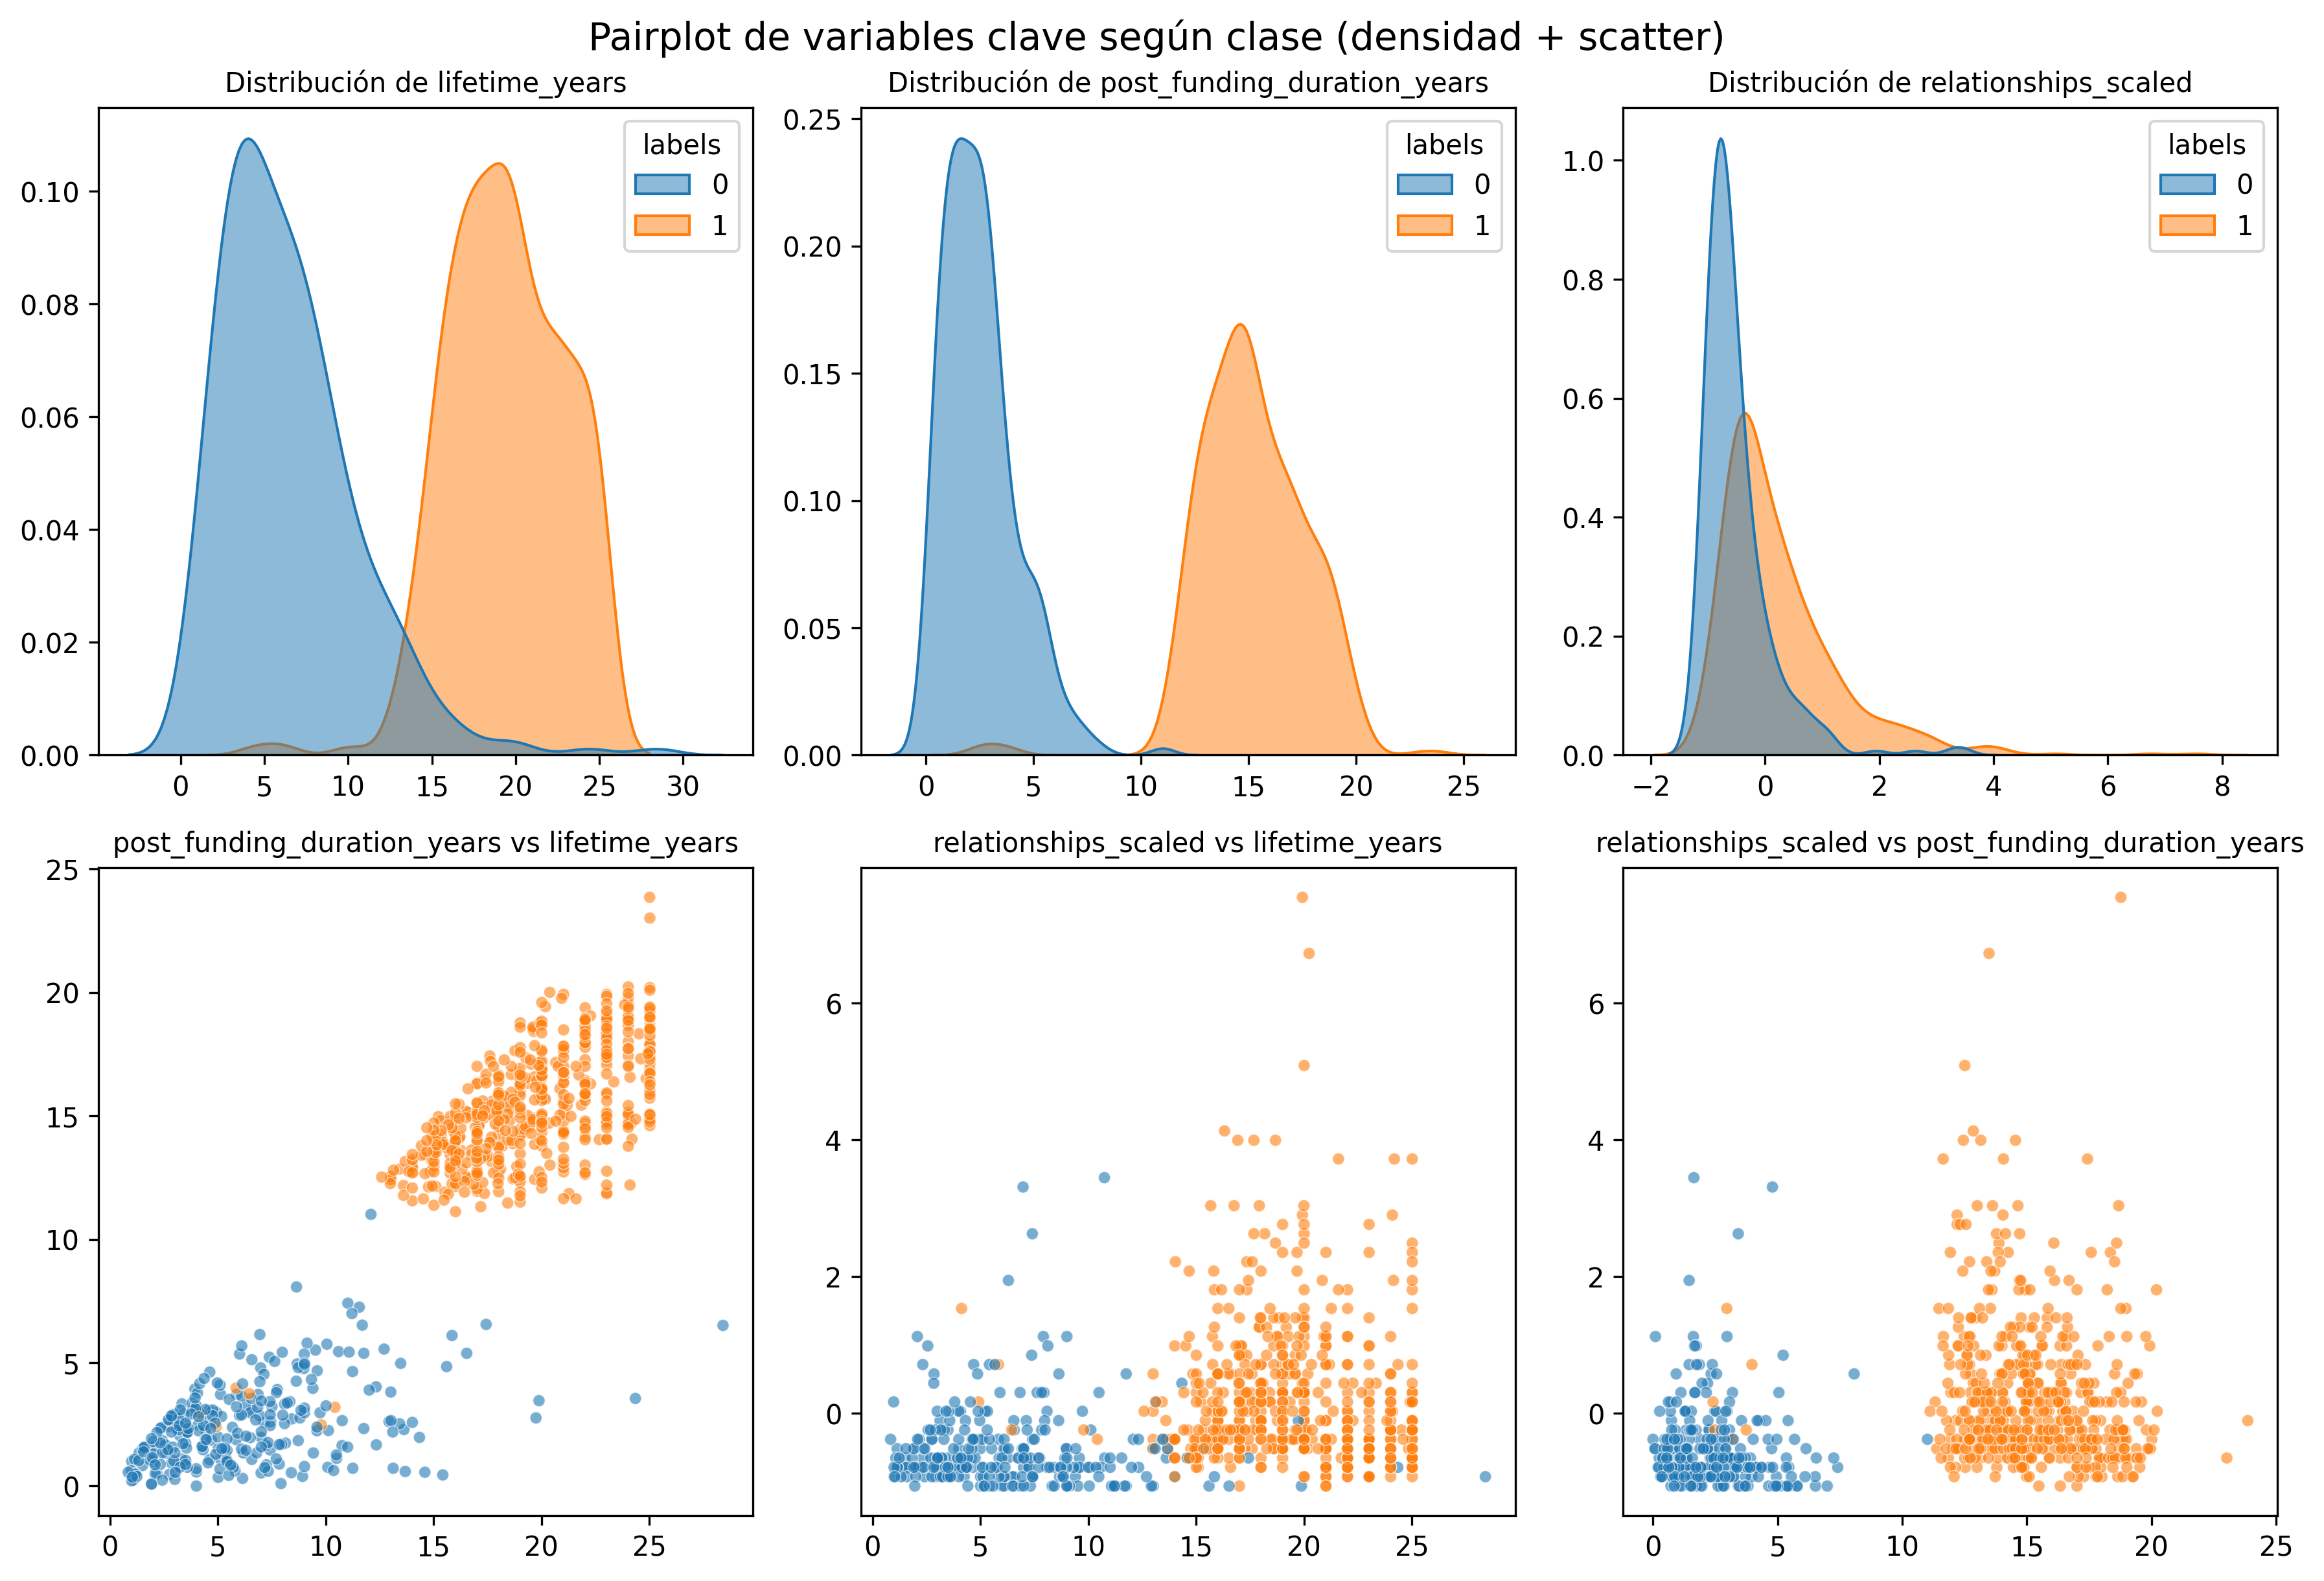

In [22]:
# ======================
# 6. Visualización de datos
# ======================

# ======================
# 6.1 Boxplots por clase para variables numéricas continuas
# ======================

numeric_cols = df.select_dtypes(include='number').columns.drop('labels')
continuous_vars = [col for col in numeric_cols if df[col].nunique() > 10]

n_cols = 3
n_rows = int(np.ceil(len(continuous_vars) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3), dpi=300)
axes = axes.flatten()

for i, col in enumerate(continuous_vars):
    sns.boxplot(data=df, x='labels', y=col, ax=axes[i])
    axes[i].set_title(f"Boxplot de {col}", fontsize=10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

# ======================
# 6.2 Pairplot entre variables significativas (collage arreglado)
# ======================

# Seleccionamos sólo las variables clave + target
pair_vars = ['lifetime_years', 'post_funding_duration_years', 'relationships_scaled', 'labels']

# Creamos un grid de subplots manual para controlar el collage
fig, axes = plt.subplots(3, 3, figsize=(12, 12), dpi=300)
axes = axes.flatten()

# Plot de densidades en diagonal
for i, var in enumerate(pair_vars[:-1]):
    sns.kdeplot(
        data=df, x=var, hue='labels',
        ax=axes[i], fill=True, common_norm=False,
        alpha=0.5, linewidth=1.0
    )
    axes[i].set_title(f"Distribución de {var}", fontsize=10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Plot de dispersión para cada par
scatter_pairs = [
    ('lifetime_years', 'post_funding_duration_years'),
    ('lifetime_years', 'relationships_scaled'),
    ('post_funding_duration_years', 'relationships_scaled')
]
for j, (xvar, yvar) in enumerate(scatter_pairs, start=3):
    sns.scatterplot(
        data=df, x=xvar, y=yvar, hue='labels',
        ax=axes[j], s=20, alpha=0.6, palette='tab10', legend=False
    )
    axes[j].set_title(f"{yvar} vs {xvar}", fontsize=10)
    axes[j].set_xlabel("")
    axes[j].set_ylabel("")

# Eliminamos ejes sobrantes
for k in range(3 + len(scatter_pairs), len(axes)):
    fig.delaxes(axes[k])

# Espacio para el título
fig.subplots_adjust(top=0.88)

# Título global
fig.suptitle("Pairplot de variables clave según clase (densidad + scatter)", fontsize=14)
fig.tight_layout()
plt.show()

# ======================
# 6.3 Collage de gráficos de barras para categóricas con <= 10 valores únicos (excluyendo city_grouped)
# ======================

cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_cols = [col for col in cat_cols if df[col].nunique() <= 10 and col != 'city_grouped']

for j in range(i + 1, len(axes2)):
    fig2.delaxes(axes2[j])

fig2.tight_layout()
plt.show()

### Interpretación de la visualización de datos

#### Boxplots por clase para variables numéricas continuas

Los boxplots permiten visualizar de forma clara las diferencias entre startups no exitosas (`labels = 0`) y exitosas (`labels = 1`) a lo largo de múltiples variables numéricas continuas:

- lifetime_years: Existe una diferencia muy marcada en la duración de vida de las startups. Las exitosas muestran una mediana alrededor de 18–20 años, mientras que las no exitosas se sitúan cerca de 5 años, y además presentan una dispersión mucho más amplia.  
- funding_delay_years: Las medianas y la dispersión intercuartílica son muy similares entre startups exitosas y no exitosas. Los outliers con retrasos excepcionalmente largos corresponden principalmente a las no exitosas.
- last_milestone_delay_years: Las startups exitosas presentan una mediana ligeramente superior en el tiempo hasta alcanzar su último hito, lo que indica una trayectoria algo más prolongada antes del cierre o fecha de corte. No obstante, las no exitosas muestran una mayor dispersión y más presencia de valores extremos, lo que sugiere que algunas experimentaron retrasos atípicamente largos en alcanzar su último hito relevante.
- post_funding_duration_years: La supervivencia tras la última financiación es claramente mayor en las exitosas, con medianas alrededor de 15–17 años frente a 2–4 años en las no exitosas, y colas que llegan hasta 25 años.  
- relationships_scaled y avg_participants_scaled: Ambas métricas de red muestran medianas superiores para las startups exitosas, y sobre todo outliers más extremos, lo que indica que las exitosas tienden a construir redes de contactos y grupos de inversores más amplios.  
- funding_total_usd_scaled: No se observa una diferencia sustancial entre startups exitosas y no exitosas en cuanto a la financiación total escalada. Ambas distribuciones están centradas en torno a valores similares, con medianas casi idénticas y una dispersión comparable, aunque se identifican outliers en ambos grupos, destacando un valor extremo mucho mayor en las startups exitosas.
- age_first_milestone_year y age_last_milestone_year: Las medianas son algo mayores en las exitosas, lo que implica que alcanzan tanto su primer hito como el último en etapas un poco más avanzadas de su ciclo de vida.

En conjunto, los boxplots evidencian que las startups exitosas no solo tienden a durar más tiempo, sino que también presentan más relaciones, mayor financiación y una evolución temporal distinta.

#### Pairplot de variables clave según clase (densidad + scatter)

El análisis visual conjunto de las variables más correlacionadas con el éxito (`labels`) refuerza las conclusiones anteriores, tanto en distribuciones individuales como en sus relaciones cruzadas:

- Distribuciones univariantes (fila superior)  
  - lifetime_years: las startups exitosas (naranja) se concentran en el rango de 15 a 25 años, mientras que las no exitosas (azul) presentan densidad en los primeros 10 años.  
  - post_funding_duration_years: comportamiento muy similar al anterior, con startups exitosas mostrando supervivencia prolongada tras la financiación.  
  - relationships_scaled: las exitosas presentan colas más largas hacia valores altos, aunque muchas también están centradas en valores bajos, reflejando heterogeneidad en sus redes.

- Dispersiones bivariantes (fila inferior)  
  - post_funding_duration_years vs lifetime_years: se observa una relación lineal creciente, especialmente pronunciada para las exitosas, que combina vida útil prolongada con largos periodos de actividad post-financiera.  
  - relationships_scaled vs lifetime_years: la tendencia es positiva, aunque más dispersa. Las startups exitosas tienden a tener más relaciones conforme aumenta su duración.  
  - relationships_scaled vs post_funding_duration_years: se mantiene una correlación positiva, pero la nube de puntos es más dispersa, lo que sugiere una relación menos fuerte pero no irrelevante entre relaciones y duración post-financiera.

Estas visualizaciones reafirman el papel clave que juegan las variables temporales y de red en la caracterización del éxito de las startups. Además, muestran que dichas variables no solo se asocian con la variable objetivo individualmente, sino también entre sí, lo que puede ser explotado por modelos de aprendizaje supervisado multivariante.

### 7. Reducción de dimensionalidad
- Aplicación de PCA y visualización en 2D o 3D  
- Visualización de componentes principales

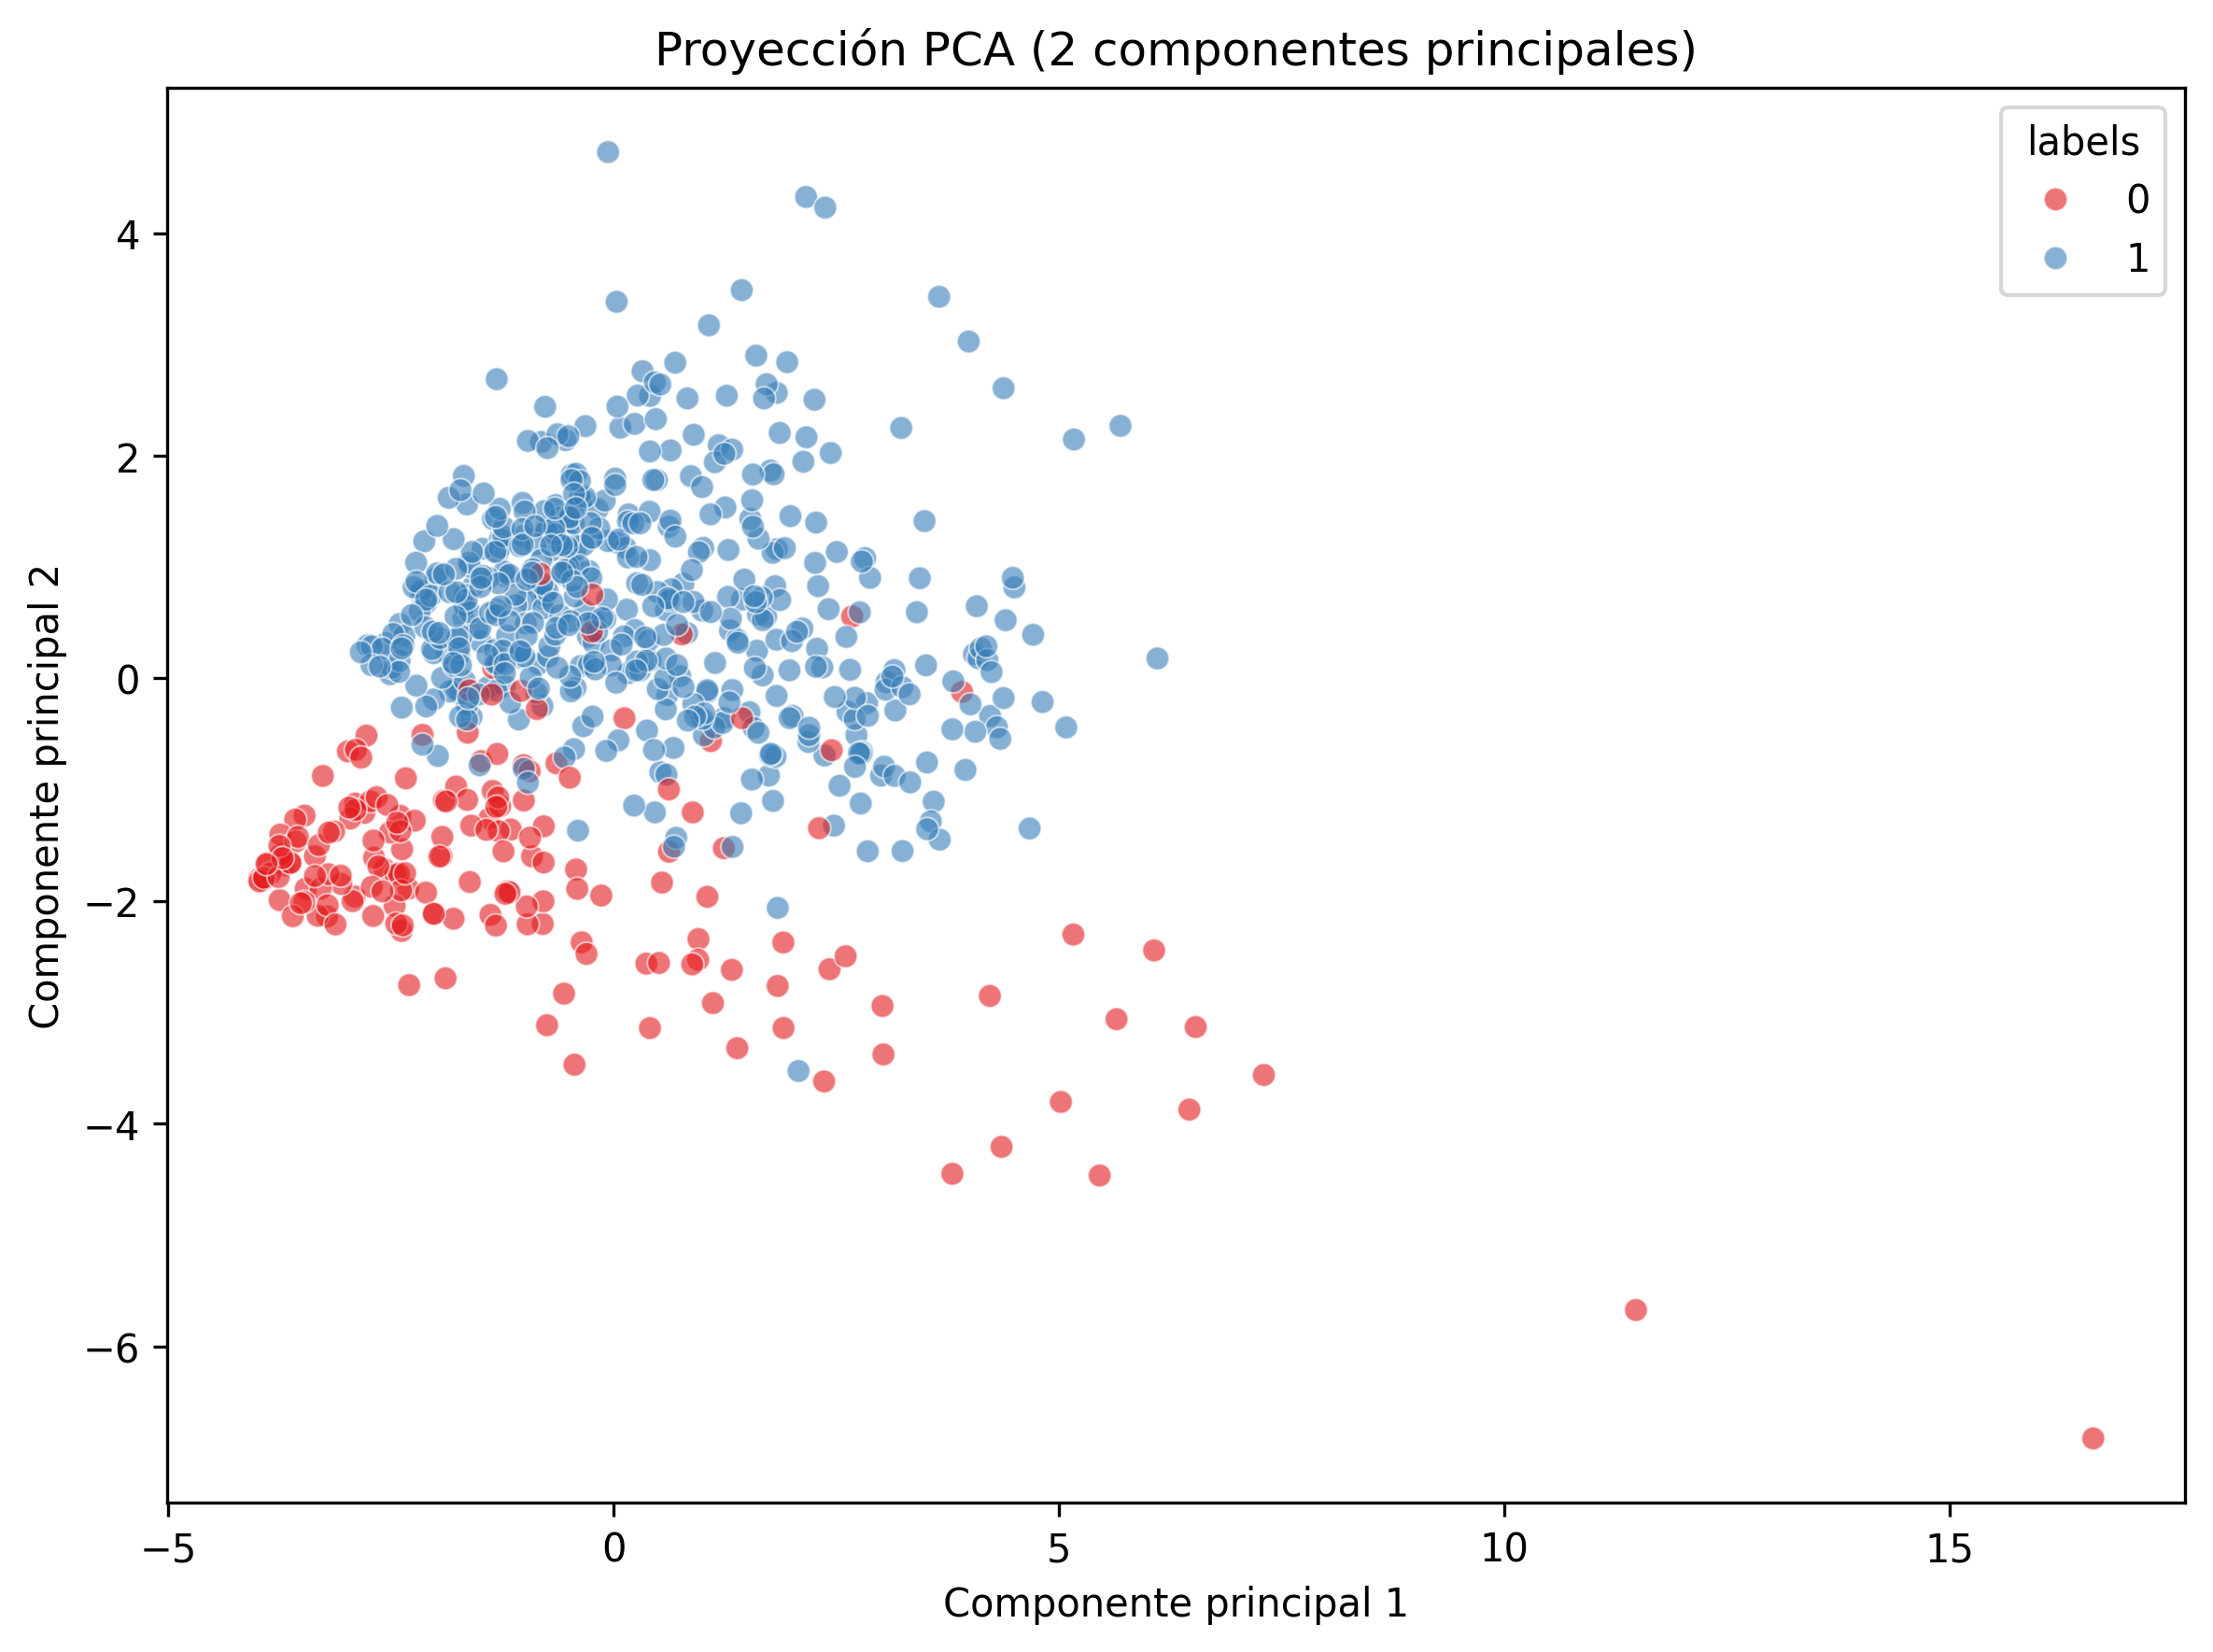

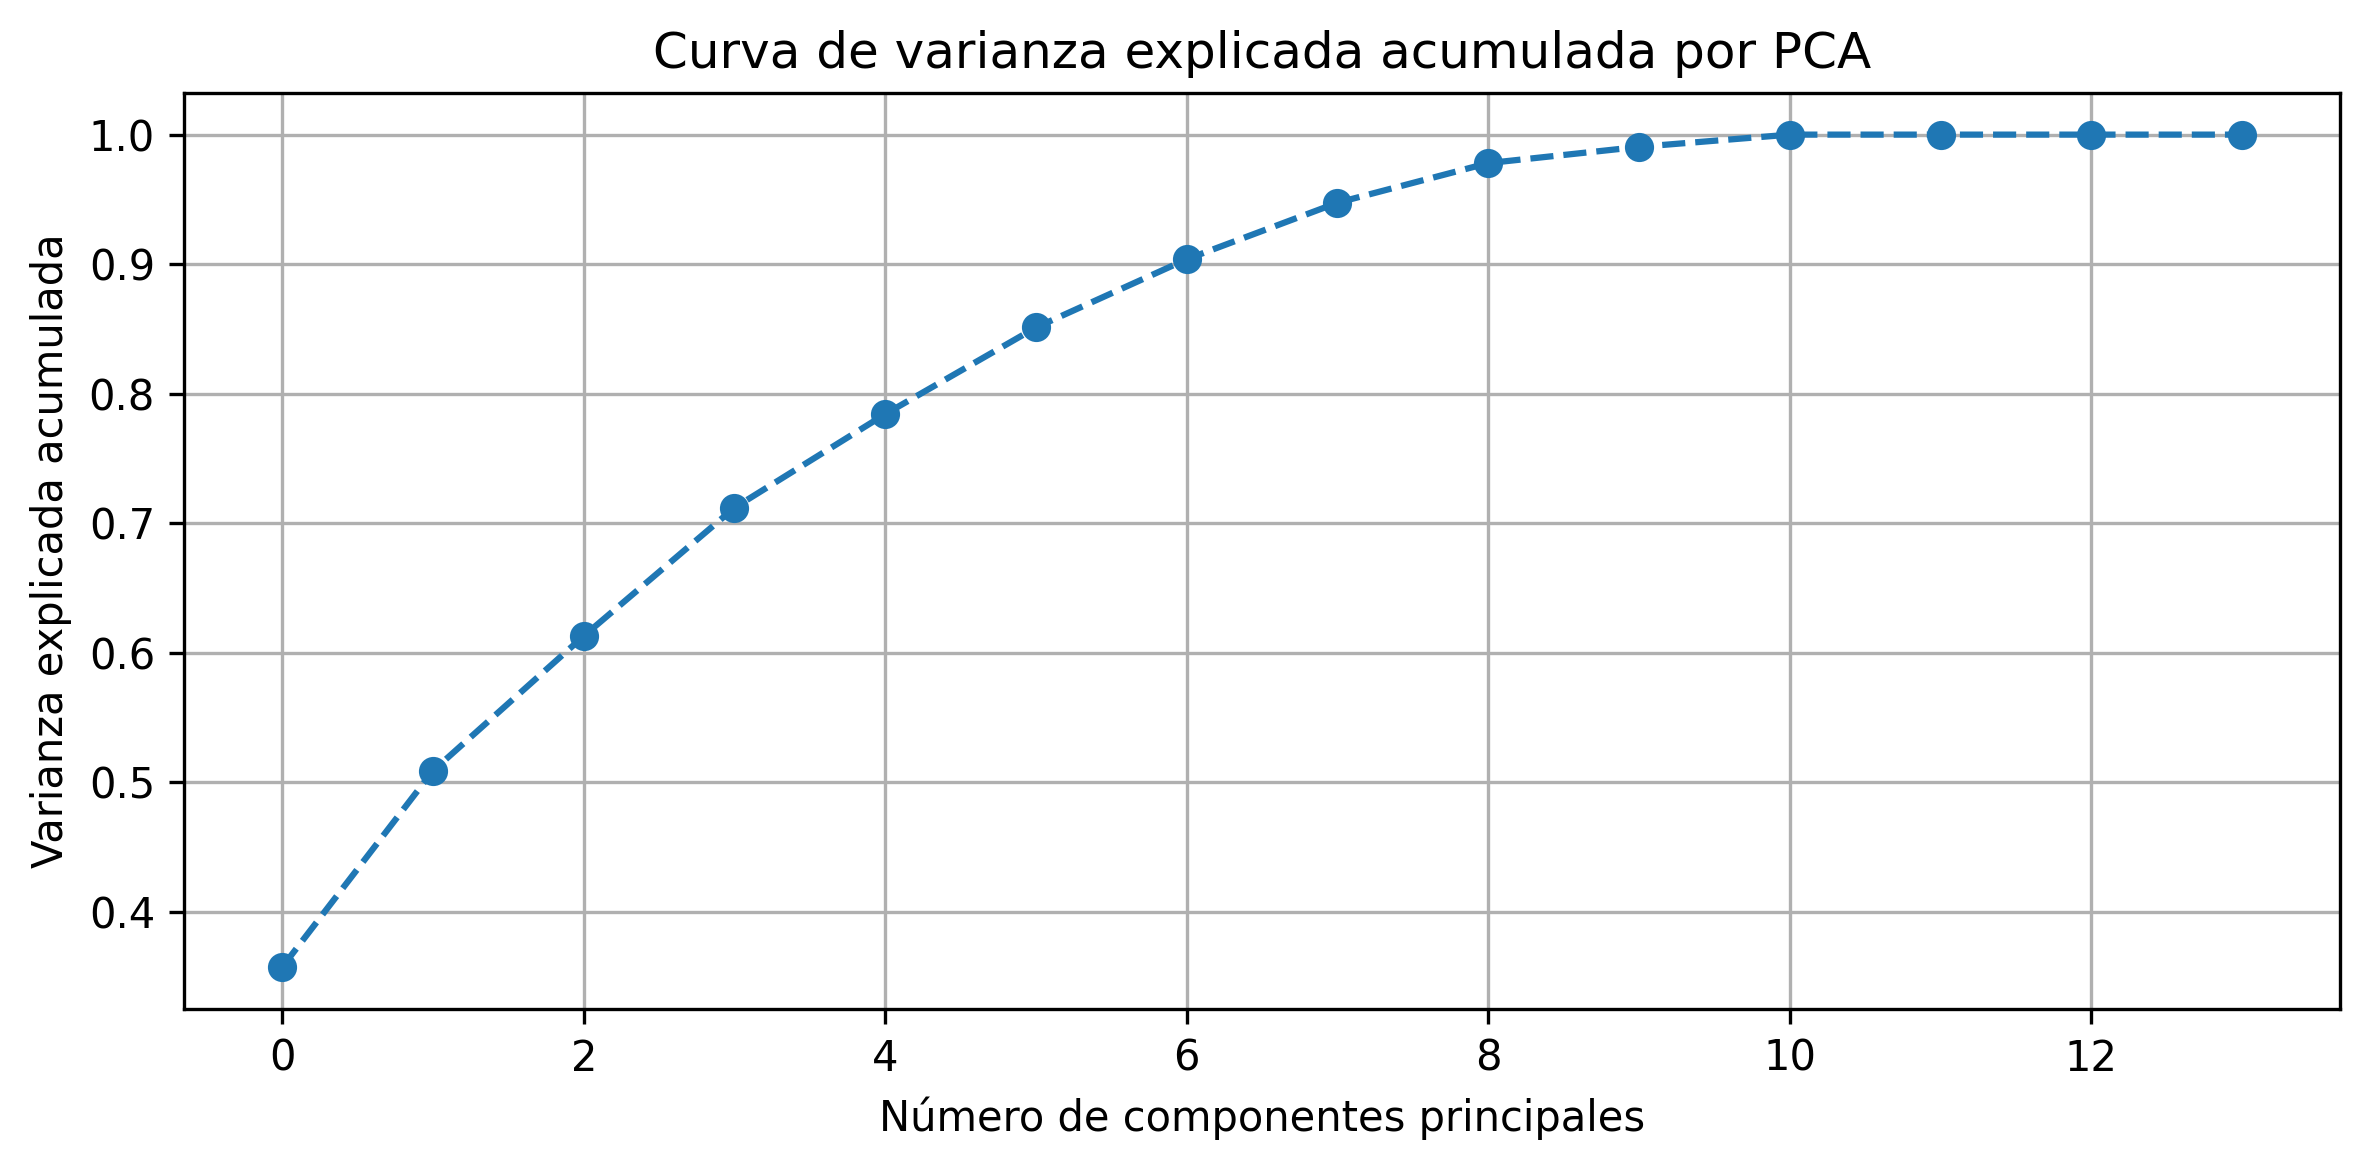

In [23]:
# ======================
# 7. Reducción de dimensionalidad con PCA
# ======================

# ======================
# 7.1 Preparación de datos para PCA
# ======================

# Seleccionamos solo las variables numéricas continuas (no binarias ni la target)
pca_vars = df.select_dtypes(include=[np.number]).drop(columns='labels')
pca_vars = pca_vars.loc[:, pca_vars.nunique() > 2]

# Eliminamos observaciones con valores nulos (solo para el PCA, no del dataset original)
pca_df = pca_vars.dropna().copy()

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_df)

# ======================
# 7.2 Aplicación de PCA (2 componentes)
# ======================

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# ======================
# 7.3 Visualización de la proyección en 2D
# ======================

# Etiquetas para colorear (se extraen respetando el índice)
labels_clean = df.loc[pca_df.index, 'labels']

plt.figure(figsize=(8, 6), dpi=300)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_clean, palette='Set1', alpha=0.6)
plt.title("Proyección PCA (2 componentes principales)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.tight_layout()
plt.show()

# ======================
# 7.4 Visualización de la varianza explicada
# ======================

pca_full = PCA()
pca_full.fit(X_scaled)
explained_var_ratio = pca_full.explained_variance_ratio_

plt.figure(figsize=(8, 4), dpi=300)
plt.plot(np.cumsum(explained_var_ratio), marker='o', linestyle='--')
plt.xlabel("Número de componentes principales")
plt.ylabel("Varianza explicada acumulada")
plt.title("Curva de varianza explicada acumulada por PCA")
plt.grid(True)
plt.tight_layout()
plt.show()

### Reducción de dimensionalidad mediante PCA

#### Proyección PCA en dos dimensiones

La proyección de los datos sobre las dos primeras componentes principales permite visualizar parcialmente la separación entre startups exitosas (`labels = 1`) y no exitosas (`labels = 0`):

- La clase 0 tiende a concentrarse en la parte inferior izquierda del plano (valores negativos en la segunda componente y cercanos a -5 en la primera), mientras que la clase 1 se agrupa en la región superior izquierda.
- Aunque existe cierta superposición entre ambas clases en la zona central del gráfico, se aprecia una estructura diferenciada que sugiere la presencia de patrones útiles para la clasificación.
- Algunos valores atípicos de la clase 0 se proyectan a zonas extremas de la primera componente, lo que podría corresponder con startups no exitosas que presentan características numéricas atípicamente altas.

Esta visualización sugiere que las dos primeras componentes capturan buena parte de la estructura discriminativa del conjunto de datos, aunque no permiten una separación completamente lineal entre clases.

#### Curva de varianza explicada acumulada

La curva acumulada muestra cuánta varianza del dataset original se preserva al proyectar los datos sobre un número creciente de componentes principales:

- La primera componente explica alrededor del 36 % de la varianza total del conjunto de datos.
- Las dos primeras componentes capturan aproximadamente un 51 % de la varianza total.
- Para explicar más del 85 % de la varianza es necesario conservar al menos 5 componentes principales.
- A partir de la séptima componente, las ganancias en varianza explicada se vuelven marginales, y se alcanza prácticamente el 100 % a partir de la décima.

Este resultado indica que es posible reducir el número de dimensiones de forma significativa (por ejemplo, de 13 a 5 componentes) sin perder información esencial, lo que facilita tanto la visualización como la construcción de modelos menos complejos.

### 8. Tratamiento de desbalanceo de clases
- Análisis del balanceo en la variable objetivo  
- Investigación acerca de la necesidad del uso de técnicas como SMOTE

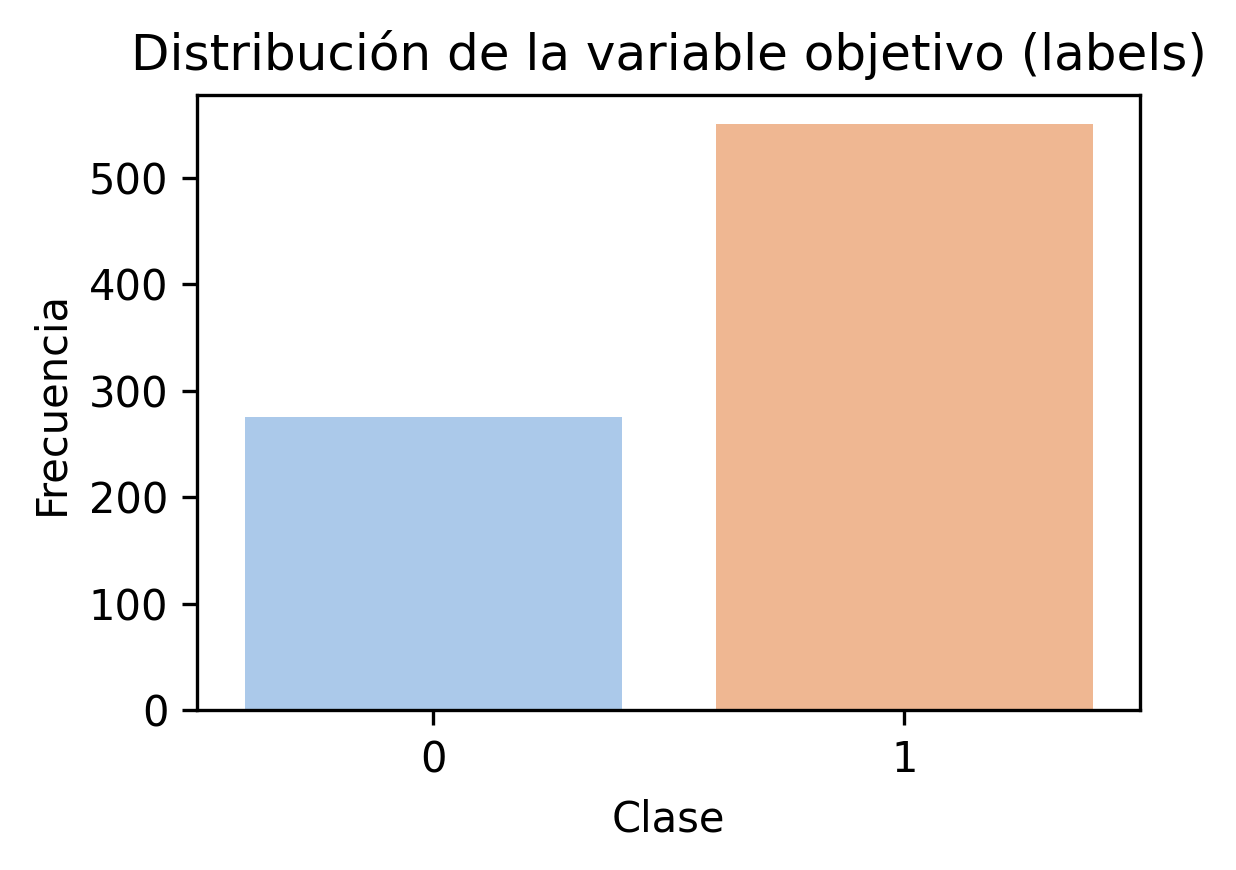

Distribución de clases en la variable objetivo

labels
1    550
0    275
Name: frecuencia, dtype: int64

labels
1    0.666667
0    0.333333
Name: proporción, dtype: float64


In [ ]:
# ======================
# 8. Tratamiento de desbalanceo de clases
# ======================

# Análisis visual del balance de clases 
plt.figure(figsize=(4, 3), dpi=300)
sns.countplot(data=df, x='labels', hue='labels', palette='pastel', legend=False)
plt.title("Distribución de la variable objetivo (labels)")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# Análisis numérico del balance de clases
print("======================")
print("Distribución de clases en la variable objetivo")
print("======================\n")
print(df['labels'].value_counts().rename("frecuencia"))
print()
print(df['labels'].value_counts(normalize=True).rename("proporción"))

### Tratamiento de desbalanceo de clases

El análisis de la variable objetivo `labels` revela un desbalance moderado entre las clases de startups:

- La clase 1 (startups exitosas) representa el 66.7 % de las observaciones, mientras que la clase 0 (no exitosas) abarca el 33.3 %.
- Esta diferencia, aunque no extremadamente pronunciada, podría afectar negativamente el rendimiento de los modelos de clasificación, especialmente en algoritmos sensibles al equilibrio entre clases.

Este desbalance sugiere que podrían considerarse estrategias de remuestreo para mitigar posibles sesgos hacia la clase mayoritaria:

- Oversampling de la clase minoritaria mediante técnicas como SMOTE.
- Undersampling de la clase mayoritaria para reducir su dominio numérico.
- Asignación de pesos de clase en modelos que lo permitan (como SVM, árboles de decisión o redes neuronales).

En cualquier caso, al tratarse de un desbalance moderado y no extremo, se recomienda realizar experimentos comparativos con y sin técnicas de balanceo y utilizar métricas robustas como el F1-score o la curva ROC-AUC para evaluar adecuadamente el rendimiento del modelo.


### 9. Selección de características
- Selección basada en correlación y visualizaciones  

In [25]:
# ======================
# 9. Selección y eliminación de variables redundantes
# ======================

# Columnas explícitas a eliminar
to_drop_explicit = [
    'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at',
    'age_first_funding_year', 'age_last_funding_year',
    'age_first_milestone_year', 'age_last_milestone_year',
    'state_code', 'zip_code', 'city', 'latitude', 'longitude',
    'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD',
    'is_top500', 'status',
    'has_milestone_info'
]

# Columnas dinámicas con prefijo 'is_'
is_cols = [col for col in df.columns if col.startswith('is_')]

# Combinar listas y asegurar unicidad
to_drop = list(set(to_drop_explicit + is_cols))

# Eliminar columnas redundantes
df.drop(columns=[c for c in to_drop if c in df.columns], inplace=True)

# Mostrar resultado
print("======================")
print("Variables eliminadas tras revisión final:")
print("======================")
print(to_drop, "\n")

print("======================")
print("Variables finales para modelado:")
print("======================")
print(df.columns.tolist())
print(f"\nNúmero total de variables: {df.shape[1]}")

Variables eliminadas tras revisión final:
['latitude', 'is_advertising', 'is_consulting', 'has_roundD', 'has_roundB', 'has_roundC', 'age_first_funding_year', 'age_last_funding_year', 'is_MA', 'is_top500', 'founded_at', 'state_code', 'is_enterprise', 'is_NY', 'city', 'is_software', 'is_othercategory', 'has_roundA', 'is_ecommerce', 'status', 'is_web', 'age_first_milestone_year', 'is_gamesvideo', 'last_funding_at', 'is_biotech', 'first_funding_at', 'zip_code', 'has_milestone_info', 'is_mobile', 'age_last_milestone_year', 'closed_at', 'is_CA', 'longitude', 'is_TX', 'is_otherstate'] 

Variables finales para modelado:
['labels', 'funding_rounds', 'has_VC', 'has_angel', 'lifetime_years', 'funding_delay_years', 'last_milestone_delay_years', 'post_funding_duration_years', 'main_sector', 'city_grouped', 'funding_total_usd_scaled', 'relationships_scaled', 'avg_participants_scaled', 'has_milestones', 'has_late_funding']

Número total de variables: 15


### Selección final de características

#### Variables eliminadas

Tras un análisis detallado del conjunto de datos y de todo el flujo de ingeniería de características, se han eliminado múltiples variables por razones de redundancia, alta cardinalidad, falta de utilidad predictiva o porque han sido reemplazadas por transformaciones más sintéticas y efectivas. A continuación, se explican los grupos de variables eliminadas:

- Coordenadas geográficas y fechas originales:

  Se eliminaron latitude, longitude, zip_code, city, state_code, closed_at, founded_at, first_funding_at y last_funding_at. Estas variables fueron utilizadas únicamente para generar nuevas variables temporales derivadas (por ejemplo, lifetime_years o post_funding_duration_years) y no aportan valor añadido por sí solas. Además, presentan problemas de granularidad o dispersión excesiva para modelos supervisados.

- Etiquetas binarias geográficas:

  Se eliminaron is_ca, is_tx, is_ny, is_ma e is_otherstate. Estas variables fueron reemplazadas por city_grouped, que proporciona una representación más robusta y menos fragmentada de la localización geográfica.

- Etiquetas binarias por sector:

  Se eliminaron is_software, is_web, is_mobile, is_enterprise, is_advertising, is_gamesvideo, is_ecommerce, is_biotech, is_consulting e is_othercategory. Todas fueron sustituidas por main_sector, una variable binaria que clasifica a las startups en tecnológicas o no tecnológicas, lo cual mejora la interpretabilidad sin aumentar la dimensionalidad.

- Financiación por etapas:

  Se eliminaron has_rounda, has_roundb, has_roundc y has_roundd. Esta información se encuentra sintetizada en la variable has_late_funding, que indica si la startup ha recibido financiación avanzada.

- Variables de edad relativas a hitos:

  Se eliminaron age_first_funding_year, age_last_funding_year, age_first_milestone_year y age_last_milestone_year. Estas variables han sido sustituidas por métricas temporales más interpretables como funding_delay_years o last_milestone_delay_years, que permiten una comparación más directa entre startups.

- Otras variables redundantes o poco informativas:
  
  Se eliminaron status, is_top500 y has_milestone_info. La variable status quedó representada completamente por labels. is_top500 no mostró relación relevante con el éxito. has_milestone_info fue reemplazada por has_milestones, que refleja mejor la existencia de hitos significativos.

#### Variables seleccionadas

Se han conservado 15 variables que capturan la información más relevante y explicativa del comportamiento de las startups:

- labels: variable objetivo binaria que indica si la startup ha sido exitosa (1) o no (0).

- funding_rounds: número total de rondas de financiación obtenidas por la startup.

- has_vc: indica si la startup ha recibido financiación de capital riesgo.

- has_angel: indica si ha recibido inversión por parte de inversores ángeles.

- lifetime_years: años totales de actividad desde la fundación hasta el cierre (o fecha de corte si sigue activa).

- funding_delay_years: tiempo transcurrido desde la fundación hasta la primera ronda de financiación.

- last_milestone_delay_years: tiempo desde la fundación hasta la última ronda de financiación registrada.

- post_funding_duration_years: duración entre la última ronda de financiación y el cierre (o fecha de corte).

- main_sector: clasificación binaria entre startup tecnológica y no tecnológica.

- city_grouped: ciudad agrupada entre hubs tecnológicos destacados o categoría other.

- funding_total_usd_scaled: financiación total acumulada, transformada mediante escalado estándar.

- relationships_scaled: número de conexiones registradas en la plataforma, escalado.

- avg_participants_scaled: media de participantes por ronda de financiación, escalado.

- has_milestones: indica si la startup ha alcanzado al menos un hito importante.

- has_late_funding: indica si la startup recibió financiación en rondas avanzadas (C o D).

Estas variables han sido seleccionadas por su capacidad explicativa, menor redundancia y coherencia estadística, conformando así el conjunto final de características para el modelado.